In [78]:
"""
CatBoost Experiments Serrano/AUDSOME Phase 1
Gabriel Iuhasz

Single Model experiment based on HPO optimization

Anomaly Only
"""

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report, accuracy_score, jaccard_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from subprocess import check_output
# from sklearn.externals import joblib
from joblib import dump, load
from catboost import CatBoostClassifier
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
%matplotlib inline

# TODO check deprecation warning xgboost
import warnings
warnings.filterwarnings('ignore')

print("Checking files in data location ...")
train_dir = '/Users/Gabriel/Dropbox/Research/ASPIDE/Datasets/ECI Chaos/Distributed Phase 1/finalized/single_node/training'
# train_dir = '/home/gabriel/Research/Aspide/workspace/data_phase'
print(check_output(["ls", train_dir]).decode("utf8"))

Checking files in data location ...
data
df_anomaly.csv
df_audsome.csv
df_clean_ausdome_single.csv
df_clean_single.csv
models
processed



In [79]:
print("Setting paths and datasets")
# Checking if directory exists for data, modells and processed

data_dir = os.path.join(train_dir,'data')
model_dir = os.path.join(train_dir,'models')
processed_dir = os.path.join(train_dir,'processed')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)


def custom_scoring_reporting(y_pred,
                             y,
                             definitions,
                             prefix):
    """
    Custom function for handling scoring and reporting
    :param y_pred: model predictions
    :param y: ground truth
    :param definitions: variable class definitions (factorize)
    :param prefix: prefix to saved files and images
    :return: 0
    """
    print("Accuracy score is: {}".format(accuracy_score(y, y_pred)))
    print("Ballanced accuracy score is: {}".format(balanced_accuracy_score(y, y_pred)))
    print("Jaccard score (micro): {}".format(jaccard_score(y, y_pred, average='micro')))
    print("Jaccard score (macro): {}".format(jaccard_score(y, y_pred, average='macro')))
    print("Jaccard score (weighted): {}".format(jaccard_score(y, y_pred, average='weighted')))


    print("Full classification report")
    print(classification_report(y, y_pred, target_names=definitions))
    report = classification_report(y, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    classification_rep_name = "{}_classification_rep_best.csv".format(prefix)
    df_classification_report.to_csv(os.path.join(model_dir,classification_rep_name), index=False)


    print("Imbalanced Classification report")
    print(classification_report_imbalanced(y, y_pred, target_names=definitions))
    imb_report = classification_report_imbalanced(y, y_pred, target_names=definitions, output_dict=True)
    df_imb_classification_report = pd.DataFrame(imb_report).transpose()
    classification_imb_rep_name = "{}_imb_classification_rep_best.csv".format(prefix)
    df_imb_classification_report.to_csv(os.path.join(model_dir,classification_imb_rep_name), index=False)

def save_valid_curve_scores(viz, param, param_range, fname):
    """
    :param viz: yellowbrick viz object
    :param param: parameter name used in validation curve
    :param fname: mL_method used
    :return: dataframe with crossvalidation scores for param and param range set by user
    """
    columns = []
    for f in range(viz.cv.n_splits):
        columns.append(f"Fold{f}")
    scores = viz.test_scores_
    df_scores = pd.DataFrame(scores, index=param_range, columns=columns)
    df_scores.to_csv(os.path.join(model_dir, f"{fname}_{param}_validationcurve_scores.csv"))
    return df_scores

Setting paths and datasets


In [80]:
df_anomaly = pd.read_csv(os.path.join(train_dir,"df_anomaly.csv"))
df_audsome = pd.read_csv(os.path.join(train_dir,"df_audsome.csv"))
df_clean = pd.read_csv(os.path.join(train_dir,"df_clean_single.csv"))
df_clean_audsome = pd.read_csv(os.path.join(train_dir,"df_clean_ausdome_single.csv"))

# Set index as time
df_anomaly.set_index('time', inplace=True)
df_audsome.set_index('time', inplace=True)
df_clean.set_index('time', inplace=True)
df_clean_audsome.set_index('time', inplace=True)

# Dirty fix for df_clean_audsome
df_clean_audsome.drop(['target_cpu_master',
       'target_mem_master', 'target_copy_master', 'target_ddot_master'], axis=1, inplace=True)
print("Dataset chosen ...")
data = df_audsome
# drop_col = ['t1','t2','t3','t4']
print("Remove unwanted columns ...")
# print("Shape before drop: {}".format(data.shape))
# data.drop(drop_col, axis=1, inplace=True)
# print("Shape after drop: {}".format(data.shape))

Dataset chosen ...
Remove unwanted columns ...


In [81]:
# Nice print
nice_y = data['target']

# Uncomment for removing dummy
# print("Removed Dummy class")
# data.loc[data.target == "dummy", 'target'] = "0"

#Creating the dependent variable class
factor = pd.factorize(data['target'])
data.target = factor[0]
definitions = factor[1]
# print(data.target.head())
# print(definitions)

Ploting class distribution ..


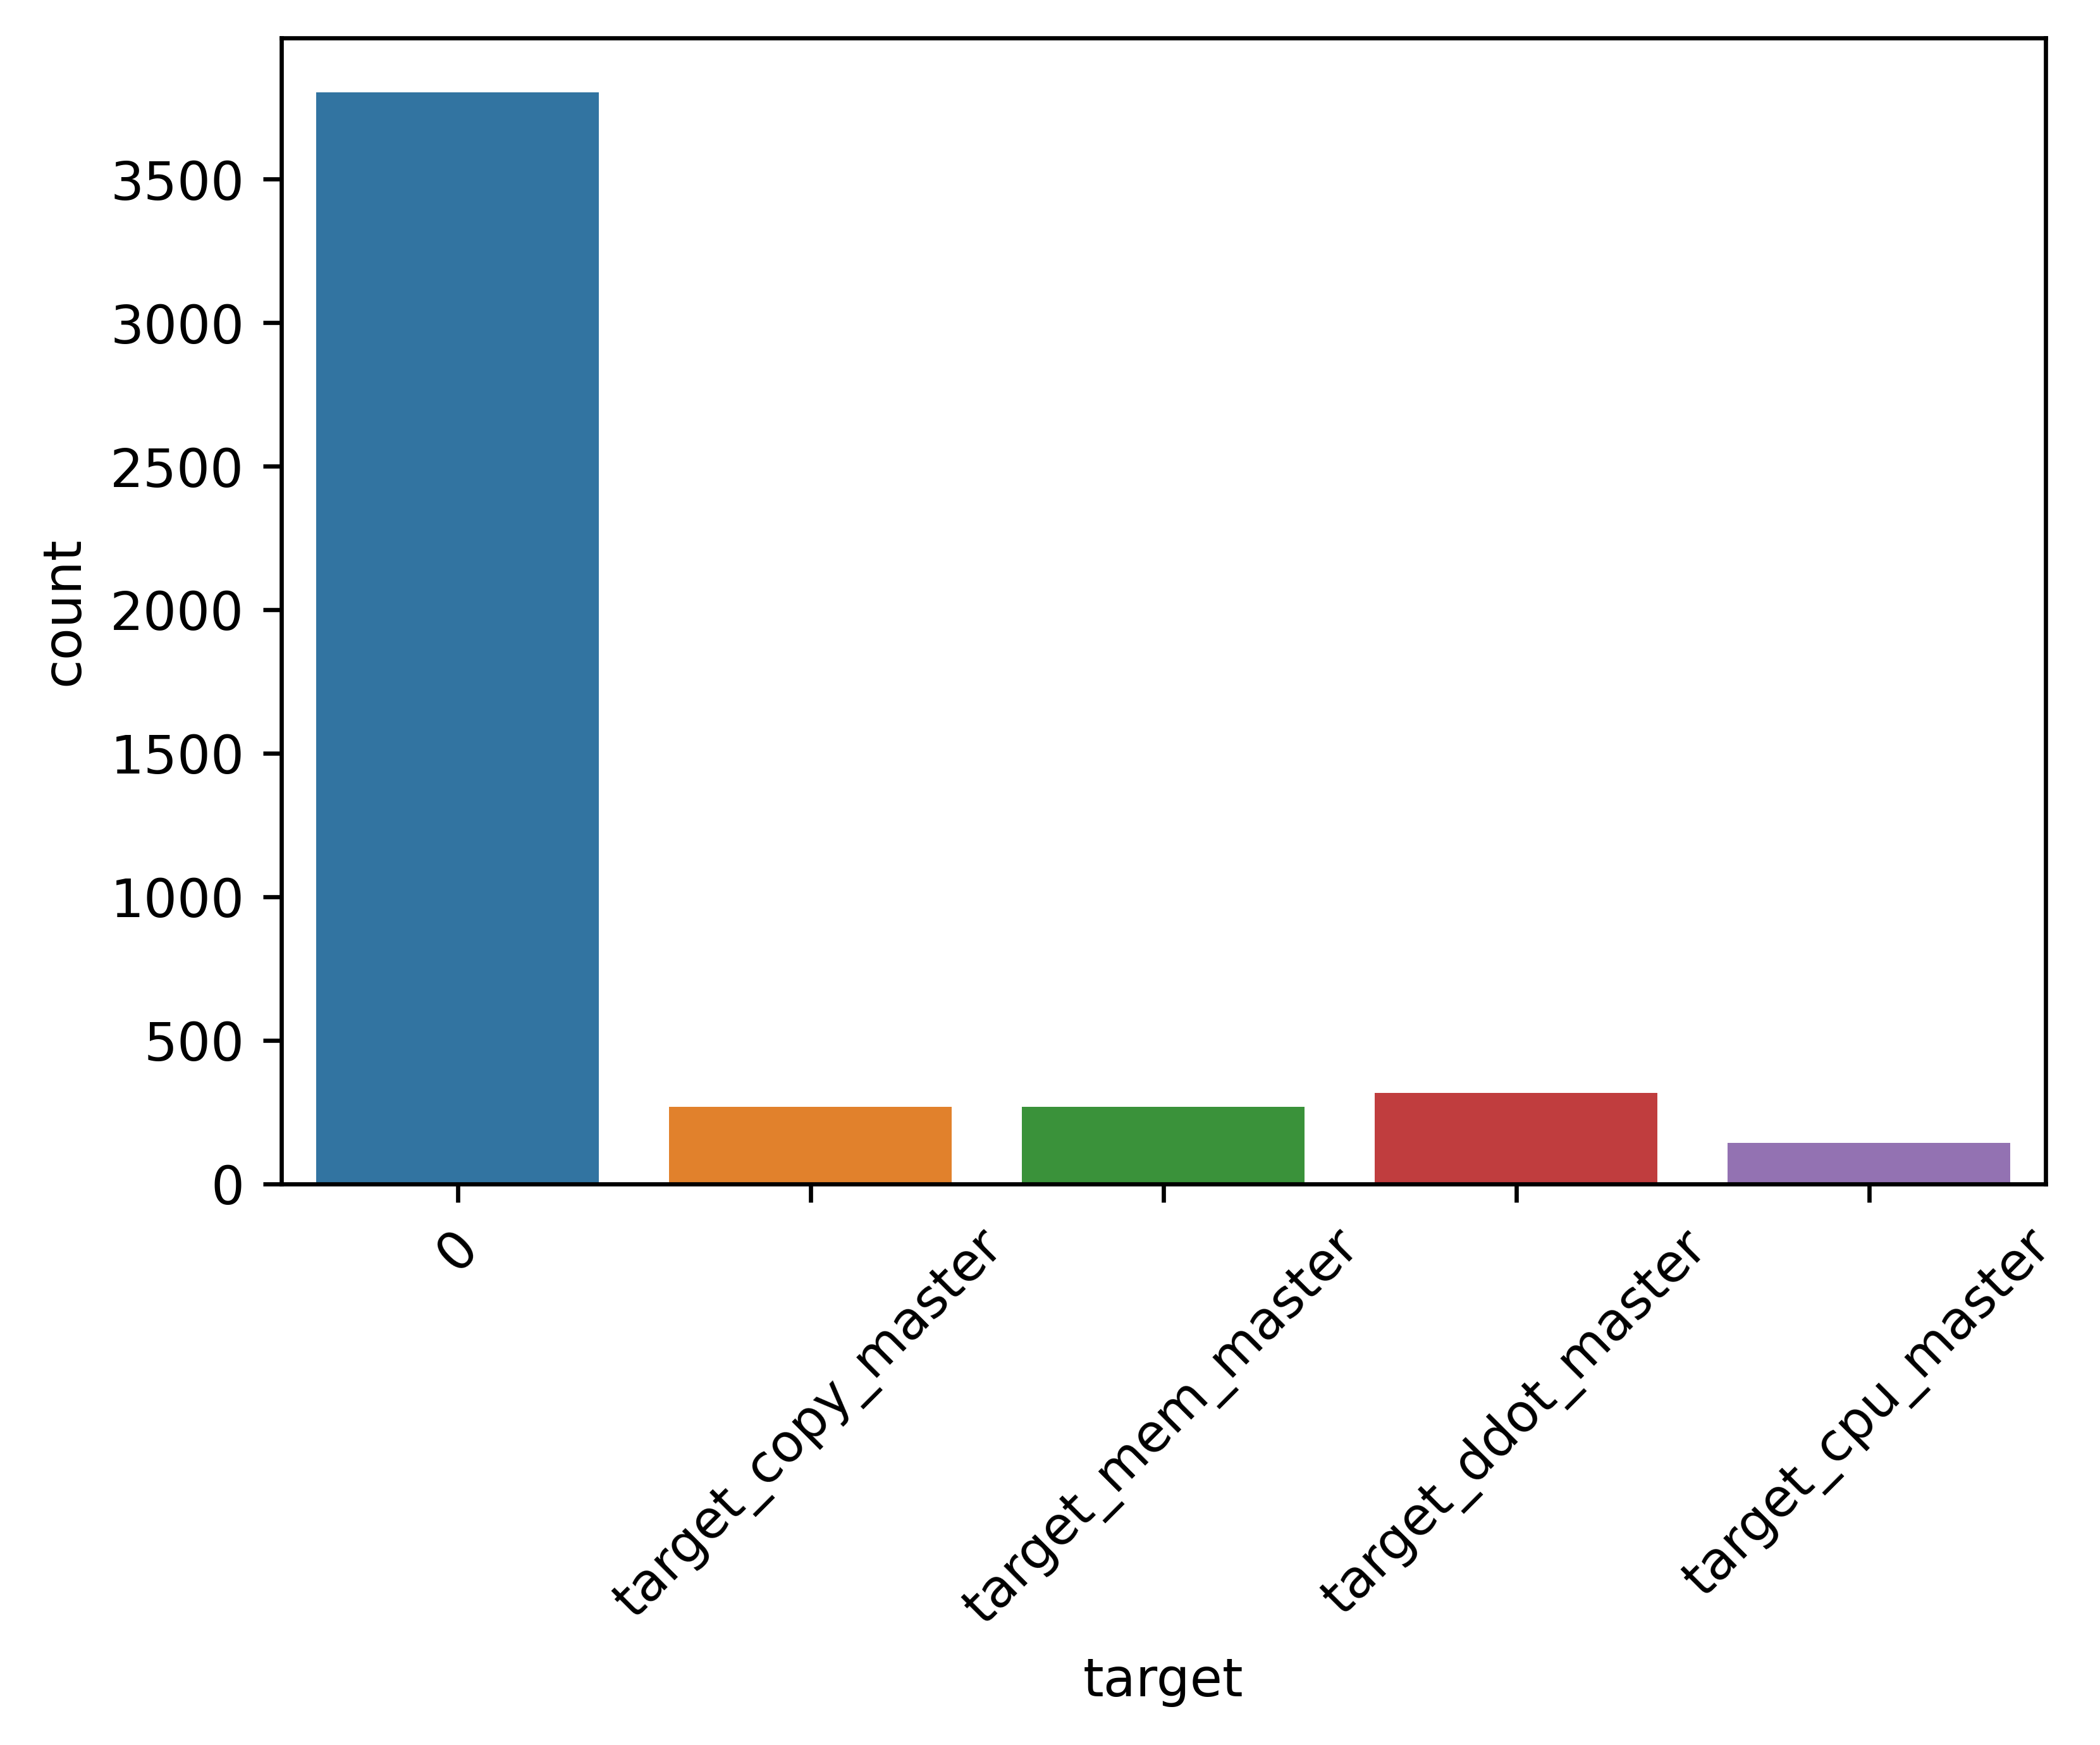

In [82]:
# Plot class distribution
print("Ploting class distribution ..")
plt.figure(dpi=600) #For publication only
class_dist_plot = sns.countplot(nice_y)
class_dist_plot.set_xticklabels(class_dist_plot.get_xticklabels(), rotation=45)
fig_cd = class_dist_plot.get_figure()
fig_cd.savefig(os.path.join(model_dir,"class_dist_single_anomaly.png"), bbox_inches='tight')

In [83]:
print("Splitting dataset into training and ground truth ...")
X = data.drop('target', axis=1)
y = data['target']

Splitting dataset into training and ground truth ...


In [84]:
print("Scaling dataset")
# scaler = StandardScaler()
# scaler = RobustScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns) #

Scaling dataset


In [85]:
# Randomforest best performing

params = {
    'depth': 6,
    'iterations': 1000,
    'learning_rate': 0.2}



clf = CatBoostClassifier()
clf.get_params().keys()

dict_keys([])

Starting fold 1
Scaling data ....
Start training ....
Learning rate set to 0.084468
0:	learn: 1.3239833	total: 23.3ms	remaining: 23.3s
1:	learn: 1.1232100	total: 31.7ms	remaining: 15.8s
2:	learn: 0.9697959	total: 39ms	remaining: 13s
3:	learn: 0.8508284	total: 46.3ms	remaining: 11.5s
4:	learn: 0.7503986	total: 54ms	remaining: 10.7s
5:	learn: 0.6694765	total: 61.1ms	remaining: 10.1s
6:	learn: 0.5982710	total: 68.3ms	remaining: 9.69s
7:	learn: 0.5404407	total: 77.1ms	remaining: 9.56s
8:	learn: 0.4885625	total: 87.6ms	remaining: 9.65s
9:	learn: 0.4428609	total: 95.2ms	remaining: 9.43s
10:	learn: 0.4031651	total: 102ms	remaining: 9.16s
11:	learn: 0.3673249	total: 109ms	remaining: 8.96s
12:	learn: 0.3365580	total: 116ms	remaining: 8.8s
13:	learn: 0.3085184	total: 123ms	remaining: 8.69s
14:	learn: 0.2831957	total: 131ms	remaining: 8.59s
15:	learn: 0.2607784	total: 139ms	remaining: 8.54s
16:	learn: 0.2395182	total: 146ms	remaining: 8.45s
17:	learn: 0.2205619	total: 153ms	remaining: 8.36s
18:	l

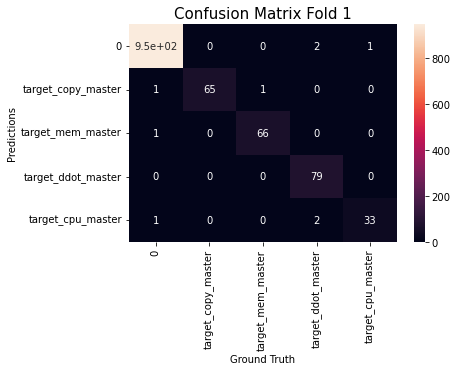

Extracting Feature improtance ...


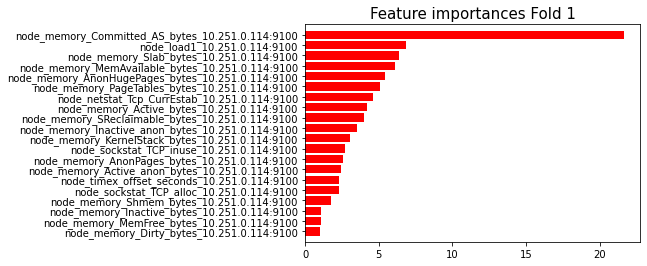

####################################################################################################
Starting fold 2
Scaling data ....
Start training ....
Learning rate set to 0.084468
0:	learn: 1.3244245	total: 12.1ms	remaining: 12.1s
1:	learn: 1.1240825	total: 21.3ms	remaining: 10.6s
2:	learn: 0.9723527	total: 30.6ms	remaining: 10.2s
3:	learn: 0.8512296	total: 38.9ms	remaining: 9.68s
4:	learn: 0.7520277	total: 46ms	remaining: 9.14s
5:	learn: 0.6705888	total: 53.1ms	remaining: 8.8s
6:	learn: 0.5995531	total: 62.1ms	remaining: 8.8s
7:	learn: 0.5416876	total: 70.4ms	remaining: 8.73s
8:	learn: 0.4924556	total: 78.1ms	remaining: 8.6s
9:	learn: 0.4475544	total: 85.8ms	remaining: 8.49s
10:	learn: 0.4066088	total: 93.9ms	remaining: 8.44s
11:	learn: 0.3702988	total: 102ms	remaining: 8.39s
12:	learn: 0.3389761	total: 110ms	remaining: 8.33s
13:	learn: 0.3112142	total: 118ms	remaining: 8.3s
14:	learn: 0.2852636	total: 125ms	remaining: 8.19s
15:	learn: 0.2635228	total: 132ms	remaining: 8.09s
16:	

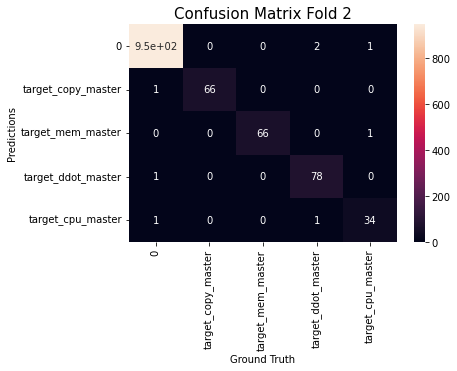

Extracting Feature improtance ...


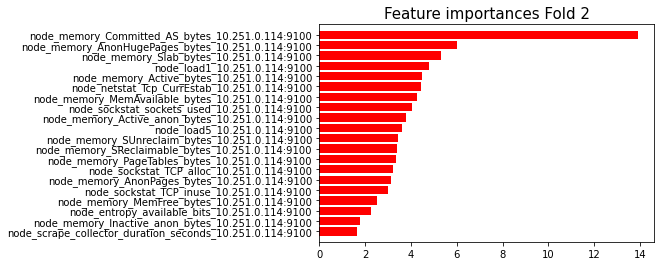

####################################################################################################
Starting fold 3
Scaling data ....
Start training ....
Learning rate set to 0.084468
0:	learn: 1.3284461	total: 8.71ms	remaining: 8.71s
1:	learn: 1.1272802	total: 15.9ms	remaining: 7.94s
2:	learn: 0.9730874	total: 24.3ms	remaining: 8.06s
3:	learn: 0.8547985	total: 32.3ms	remaining: 8.05s
4:	learn: 0.7548115	total: 38.8ms	remaining: 7.73s
5:	learn: 0.6698798	total: 45.2ms	remaining: 7.48s
6:	learn: 0.6002001	total: 54.5ms	remaining: 7.74s
7:	learn: 0.5415726	total: 62ms	remaining: 7.69s
8:	learn: 0.4905775	total: 71ms	remaining: 7.82s
9:	learn: 0.4448166	total: 84.6ms	remaining: 8.38s
10:	learn: 0.4051163	total: 92.5ms	remaining: 8.32s
11:	learn: 0.3680249	total: 100ms	remaining: 8.23s
12:	learn: 0.3380500	total: 107ms	remaining: 8.1s
13:	learn: 0.3097253	total: 114ms	remaining: 8.05s
14:	learn: 0.2847020	total: 122ms	remaining: 8.01s
15:	learn: 0.2625257	total: 130ms	remaining: 7.97s
16:

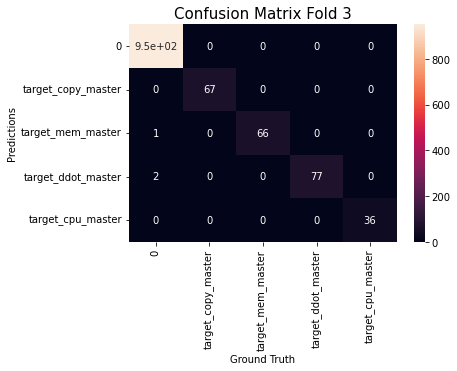

Extracting Feature improtance ...


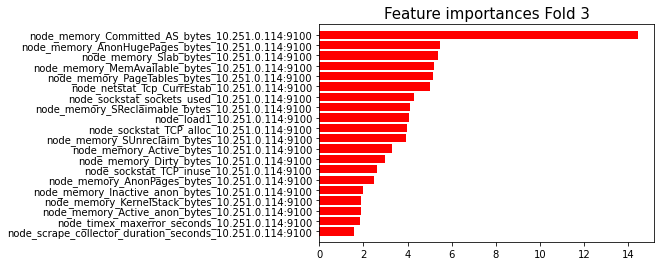

####################################################################################################
Starting fold 4
Scaling data ....
Start training ....
Learning rate set to 0.084468
0:	learn: 1.3157286	total: 9.22ms	remaining: 9.21s
1:	learn: 1.1172626	total: 18.1ms	remaining: 9.04s
2:	learn: 0.9669157	total: 28.7ms	remaining: 9.52s
3:	learn: 0.8547375	total: 37.6ms	remaining: 9.36s
4:	learn: 0.7553212	total: 44.8ms	remaining: 8.92s
5:	learn: 0.6701954	total: 51.6ms	remaining: 8.54s
6:	learn: 0.5992371	total: 59.4ms	remaining: 8.42s
7:	learn: 0.5403220	total: 68.3ms	remaining: 8.46s
8:	learn: 0.4905035	total: 79.4ms	remaining: 8.74s
9:	learn: 0.4461917	total: 87.5ms	remaining: 8.66s
10:	learn: 0.4063988	total: 95.3ms	remaining: 8.56s
11:	learn: 0.3703272	total: 105ms	remaining: 8.61s
12:	learn: 0.3394293	total: 112ms	remaining: 8.5s
13:	learn: 0.3107227	total: 121ms	remaining: 8.5s
14:	learn: 0.2858369	total: 129ms	remaining: 8.46s
15:	learn: 0.2613710	total: 136ms	remaining: 8.37s


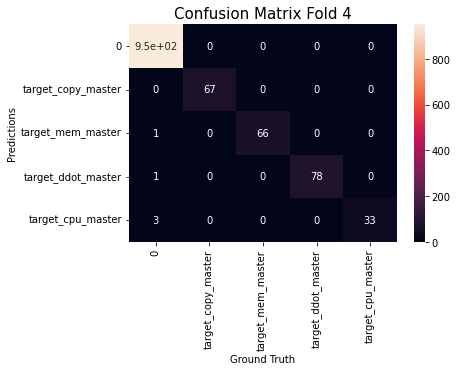

Extracting Feature improtance ...


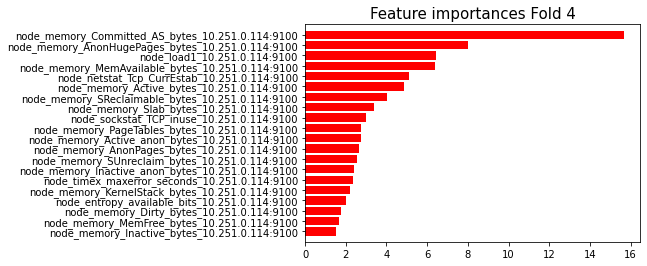

####################################################################################################
Starting fold 5
Scaling data ....
Start training ....
Learning rate set to 0.084468
0:	learn: 1.3250476	total: 7.58ms	remaining: 7.57s
1:	learn: 1.1276099	total: 15.5ms	remaining: 7.73s
2:	learn: 0.9742492	total: 25.4ms	remaining: 8.43s
3:	learn: 0.8542234	total: 36.7ms	remaining: 9.13s
4:	learn: 0.7558314	total: 45.2ms	remaining: 8.99s
5:	learn: 0.6764177	total: 63.2ms	remaining: 10.5s
6:	learn: 0.6044983	total: 67.5ms	remaining: 9.57s
7:	learn: 0.5460298	total: 74.6ms	remaining: 9.25s
8:	learn: 0.4956089	total: 81.3ms	remaining: 8.95s
9:	learn: 0.4512979	total: 88ms	remaining: 8.71s
10:	learn: 0.4107142	total: 94.8ms	remaining: 8.53s
11:	learn: 0.3746056	total: 102ms	remaining: 8.43s
12:	learn: 0.3420903	total: 110ms	remaining: 8.35s
13:	learn: 0.3127884	total: 118ms	remaining: 8.28s
14:	learn: 0.2864933	total: 128ms	remaining: 8.43s
15:	learn: 0.2639006	total: 136ms	remaining: 8.36s


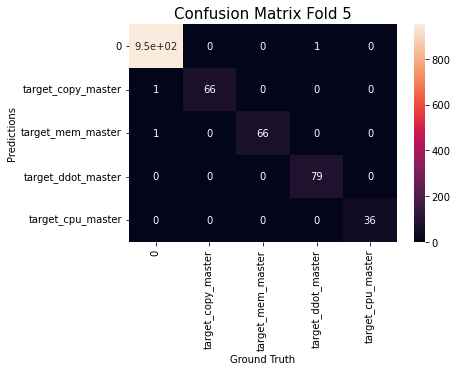

Extracting Feature improtance ...


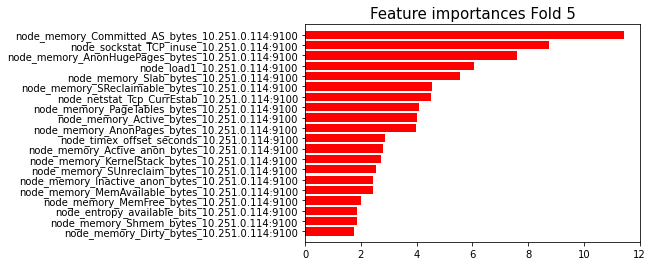

####################################################################################################


In [86]:
# skFold = StratifiedKFold(n_splits=5)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=21)
ml_method = 'catboost_best_cfg_audsome_v1'
print("="*100)
clf_models = []
report = {
    "Accuracy": [],
    "BallancedAccuracy": [],
    "Jaccard": []
}
fold = 1
for train_index, test_index in sss.split(X, y):
    # print("Train:", train_index, "Test:", test_index)
    print("Starting fold {}".format(fold))
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
    print("Scaling data ....")
    Xtrain = scaler.fit_transform(Xtrain)
    Xtest = scaler.transform(Xtest)
    print("Start training ....")
    clf.fit(Xtrain, ytrain)
    # Append model
    clf_models.append(clf)
    print("Predicting ....")
    ypred = clf.predict(Xtest)
    print("-"*100)
    acc = accuracy_score(ytest, ypred)
    report['Accuracy'].append(acc)
    print("Accuracy score fold {} is: {}".format(fold, acc))
    bacc = balanced_accuracy_score(ytest, ypred)
    report['BallancedAccuracy'].append(bacc)
    print("Ballanced accuracy fold {} score is: {}".format(fold, bacc))
    jaccard = jaccard_score(ytest, ypred, average='micro')
    print("Jaccard score fold {}: {}".format(fold, jaccard))
    report['Jaccard'].append(jaccard)

    ###
    print("Full classification report for fold {}".format(fold))
    print(classification_report(ytest, ypred, digits=4,target_names=definitions))

    cf_report = classification_report(ytest, ypred, output_dict=True, digits=4, target_names=definitions)
    df_classification_report = pd.DataFrame(cf_report).transpose()
    print("Saving classification report")
    classification_rep_name = "classification_{}_fold_{}.csv".format(ml_method, fold)
    df_classification_report.to_csv(os.path.join(model_dir,classification_rep_name), index=False)


    ###
    print("Imbalanced Classification report for fold {}".format(fold))
    print(classification_report_imbalanced(ytest, ypred, digits=4, target_names=definitions))
    imb_cf_report = classification_report_imbalanced(ytest, ypred, output_dict=True, digits=4, target_names=definitions)
    df_imb_classification_report = pd.DataFrame(imb_cf_report).transpose()
    print("Saving imbalanced classification report")
    imb_classification_rep_name = "imb_classification_{}_fold_{}.csv".format(ml_method, fold)
    df_imb_classification_report.to_csv(os.path.join(model_dir,imb_classification_rep_name), index=False)
    ###
    print("Generating confusion matrix fold {}".format(fold))
    cf_matrix = confusion_matrix(ytest, ypred)

    # plt.figure(figsize=(10,20), dpi=600) For publication only
    ht_cf=sns.heatmap(cf_matrix, annot=True, yticklabels=list(definitions), xticklabels=list(definitions))
    plt.title('Confusion Matrix Fold {}'.format(fold), fontsize = 15) # title with fontsize 20
    plt.xlabel('Ground Truth', fontsize = 10) # x-axis label with fontsize 15
    plt.ylabel('Predictions', fontsize = 10) # y-axis label with fontsize 15
    cf_fig = "CM_{}_{}.png".format(ml_method, fold)
    ht_cf.figure.savefig(os.path.join(model_dir, cf_fig), bbox_inches='tight')
    plt.show()


    print("Extracting Feature improtance ...")
    feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
    sorted_feature = feat_importances.sort_values(ascending=True)
    # print(sorted_feature.head(-10))
    # print(type(sorted_feature.tail(15)))
    # print(X.shape[1])

    # Number of columns
    # print(len(sorted_feature))

    # Limit number of sorted features
    sorted_feature = sorted_feature.tail(20)



    # n_col = X.shape[1]
    n_col = len(sorted_feature)

    # Plot the feature importances of the forest
    # plt.figure(figsize=(10,20), dpi=600) For publication only
    plt.title("Feature importances Fold {}".format(fold), fontsize = 15)
    plt.barh(range(n_col), sorted_feature,
           color="r", align="center")
    # If you want to define your own labels,
    # change indices to a list of labels on the following line.
    plt.yticks(range(n_col), sorted_feature.index)
    plt.ylim([-1, n_col])
    fi_fig = "FI_{}_{}.png".format(ml_method, fold)
    plt.savefig(os.path.join(model_dir, fi_fig), bbox_inches='tight')
    plt.show()
    #increment fold count
    fold+=1
    print("#"*100)

In [87]:
print("Saving final report ...")
# Validation Report
df_report = pd.DataFrame(report)
final_report = "Model_{}_report.csv".format(ml_method)
df_report.to_csv(os.path.join(model_dir,final_report), index=False)

Saving final report ...


In [89]:
# Calculates feature statistics for CatBoost
"""
The X-axis of the resulting chart contains values of the feature divided into buckets. For numerical features, the splits between buckets represent conditions (feature < value) from the trees of the model. For categorical features, each bucket stands for a category.
The Y-axis of the resulting chart contains the following graphs:
Average target (label) value in the bucket.
Average prediction in the bucket.
Number of objects in the bucket.
Average predictions on varying values of the feature.
To calculate it, the value of the feature is successively changed to fall into every bucket for every input object. The value for a bucket on the graph is calculated as the average for all objects when their feature values are changed to fall into this bucket.
The return value of the function contains the data from these graps.
"""
res = clf.calc_feature_statistics(X,
                                    y,
                                    feature=list(range(0, len(X.columns.values))),
                                    plot=True)

# res = clf.calc_feature_statistics(X,
#                                   y,
#                                   feature = list(X.columns.values),
#                                   plot=True)


In [90]:
from catboost import cv
from catboost import Pool

params_cbcv  = {
    'depth': 6,
    'iterations': 1000,
    'learning_rate': 0.2,
    'custom_loss': 'F1',
    'loss_function': 'MultiClass'
}




cv_data = cv(
    params=params_cbcv,
    pool=Pool(X, label=y),
    shuffle=True,
    plot=True,
    stratified=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [91]:

from catboost.utils import get_roc_curve, get_fnr_curve
params_2 = {
    'depth': 6,
    'iterations': 1000,
    'learning_rate': 0.2,
#     'classes_count': 5,
    'loss_function': 'MultiClass',
#     'eval_metric': 'Accuracy'
}


clf_2 = CatBoostClassifier(**params_2)
clf_2.fit(X, y, plot=True)
# catboost_pool = Pool(X, y)
# roc_curve_values = get_roc_curve(clf_2, catboost_pool)
# (thresholds, fnr) = get_fnr_curve(curve=roc_curve_values, plot=True)

# fi = clf.get_feature_importance(data=X, reference_data=y)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9571321	total: 15.2ms	remaining: 15.2s
1:	learn: 0.6975159	total: 27.6ms	remaining: 13.8s
2:	learn: 0.5304938	total: 41.1ms	remaining: 13.7s
3:	learn: 0.4163553	total: 52ms	remaining: 13s
4:	learn: 0.3321687	total: 63ms	remaining: 12.5s
5:	learn: 0.2687645	total: 76.6ms	remaining: 12.7s
6:	learn: 0.2220689	total: 87ms	remaining: 12.3s
7:	learn: 0.1813787	total: 96.5ms	remaining: 12s
8:	learn: 0.1502032	total: 104ms	remaining: 11.5s
9:	learn: 0.1253845	total: 114ms	remaining: 11.3s
10:	learn: 0.1060370	total: 122ms	remaining: 10.9s
11:	learn: 0.0905245	total: 131ms	remaining: 10.8s
12:	learn: 0.0784369	total: 143ms	remaining: 10.9s
13:	learn: 0.0680391	total: 155ms	remaining: 10.9s
14:	learn: 0.0601140	total: 166ms	remaining: 10.9s
15:	learn: 0.0525368	total: 178ms	remaining: 10.9s
16:	learn: 0.0471841	total: 187ms	remaining: 10.8s
17:	learn: 0.0421783	total: 198ms	remaining: 10.8s
18:	learn: 0.0383041	total: 207ms	remaining: 10.7s
19:	learn: 0.0350594	total: 221ms	remaining

In [92]:
catboost_pool = Pool(X, y)

# roc_curve_values = get_roc_curve(clf_2, catboost_pool)
# (thresholds, fnr) = get_fnr_curve(curve=roc_curve_values, plot=True)

fi = clf_2.get_feature_importance(catboost_pool)
fi

array([1.80069320e-01, 0.00000000e+00, 2.40781676e-01, 0.00000000e+00,
       0.00000000e+00, 9.73696299e-03, 3.83902216e-01, 0.00000000e+00,
       9.24867174e-03, 1.39025005e-02, 2.14074225e-02, 3.26011706e-02,
       1.67943858e+00, 5.05220582e-01, 1.54234841e-02, 8.39263646e-02,
       5.03315587e+00, 4.64523590e-01, 8.45448593e-01, 4.42048799e+00,
       3.21438337e+00, 1.01277497e+00, 4.97493428e+00, 1.89471980e+00,
       3.07856059e-01, 1.49807979e+00, 1.83840070e+01, 0.00000000e+00,
       0.00000000e+00, 2.43894793e+00, 2.24323131e+00, 1.08331496e+00,
       7.97993569e-01, 1.04369682e+00, 1.67971983e+00, 4.49685925e+00,
       1.67727176e+00, 6.20646399e+00, 3.64054166e+00, 3.24237374e+00,
       2.06317202e+00, 4.65991212e+00, 4.67949799e-02, 0.00000000e+00,
       5.30748870e-03, 0.00000000e+00, 9.63885876e-04, 0.00000000e+00,
       0.00000000e+00, 1.57741865e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.89416856e-04, 3.34967006e-01,
      

0:	learn: 1.2179107	total: 24.6ms	remaining: 24.6s
1:	learn: 1.0492430	total: 33.7ms	remaining: 16.8s
2:	learn: 0.9465365	total: 46.5ms	remaining: 15.4s
3:	learn: 0.8805067	total: 54.3ms	remaining: 13.5s
4:	learn: 0.8351879	total: 60.4ms	remaining: 12s
5:	learn: 0.8029766	total: 66.5ms	remaining: 11s
6:	learn: 0.7801379	total: 74.2ms	remaining: 10.5s
7:	learn: 0.7635139	total: 81.4ms	remaining: 10.1s
8:	learn: 0.7513679	total: 88.5ms	remaining: 9.74s
9:	learn: 0.7412652	total: 94.8ms	remaining: 9.38s
10:	learn: 0.7308264	total: 102ms	remaining: 9.21s
11:	learn: 0.7237928	total: 110ms	remaining: 9.06s
12:	learn: 0.7194866	total: 116ms	remaining: 8.83s
13:	learn: 0.7157969	total: 127ms	remaining: 8.96s
14:	learn: 0.7118160	total: 134ms	remaining: 8.8s
15:	learn: 0.7093432	total: 142ms	remaining: 8.7s
16:	learn: 0.7067263	total: 150ms	remaining: 8.69s
17:	learn: 0.7041471	total: 159ms	remaining: 8.7s
18:	learn: 0.6988060	total: 169ms	remaining: 8.71s
19:	learn: 0.6972602	total: 175ms	rema

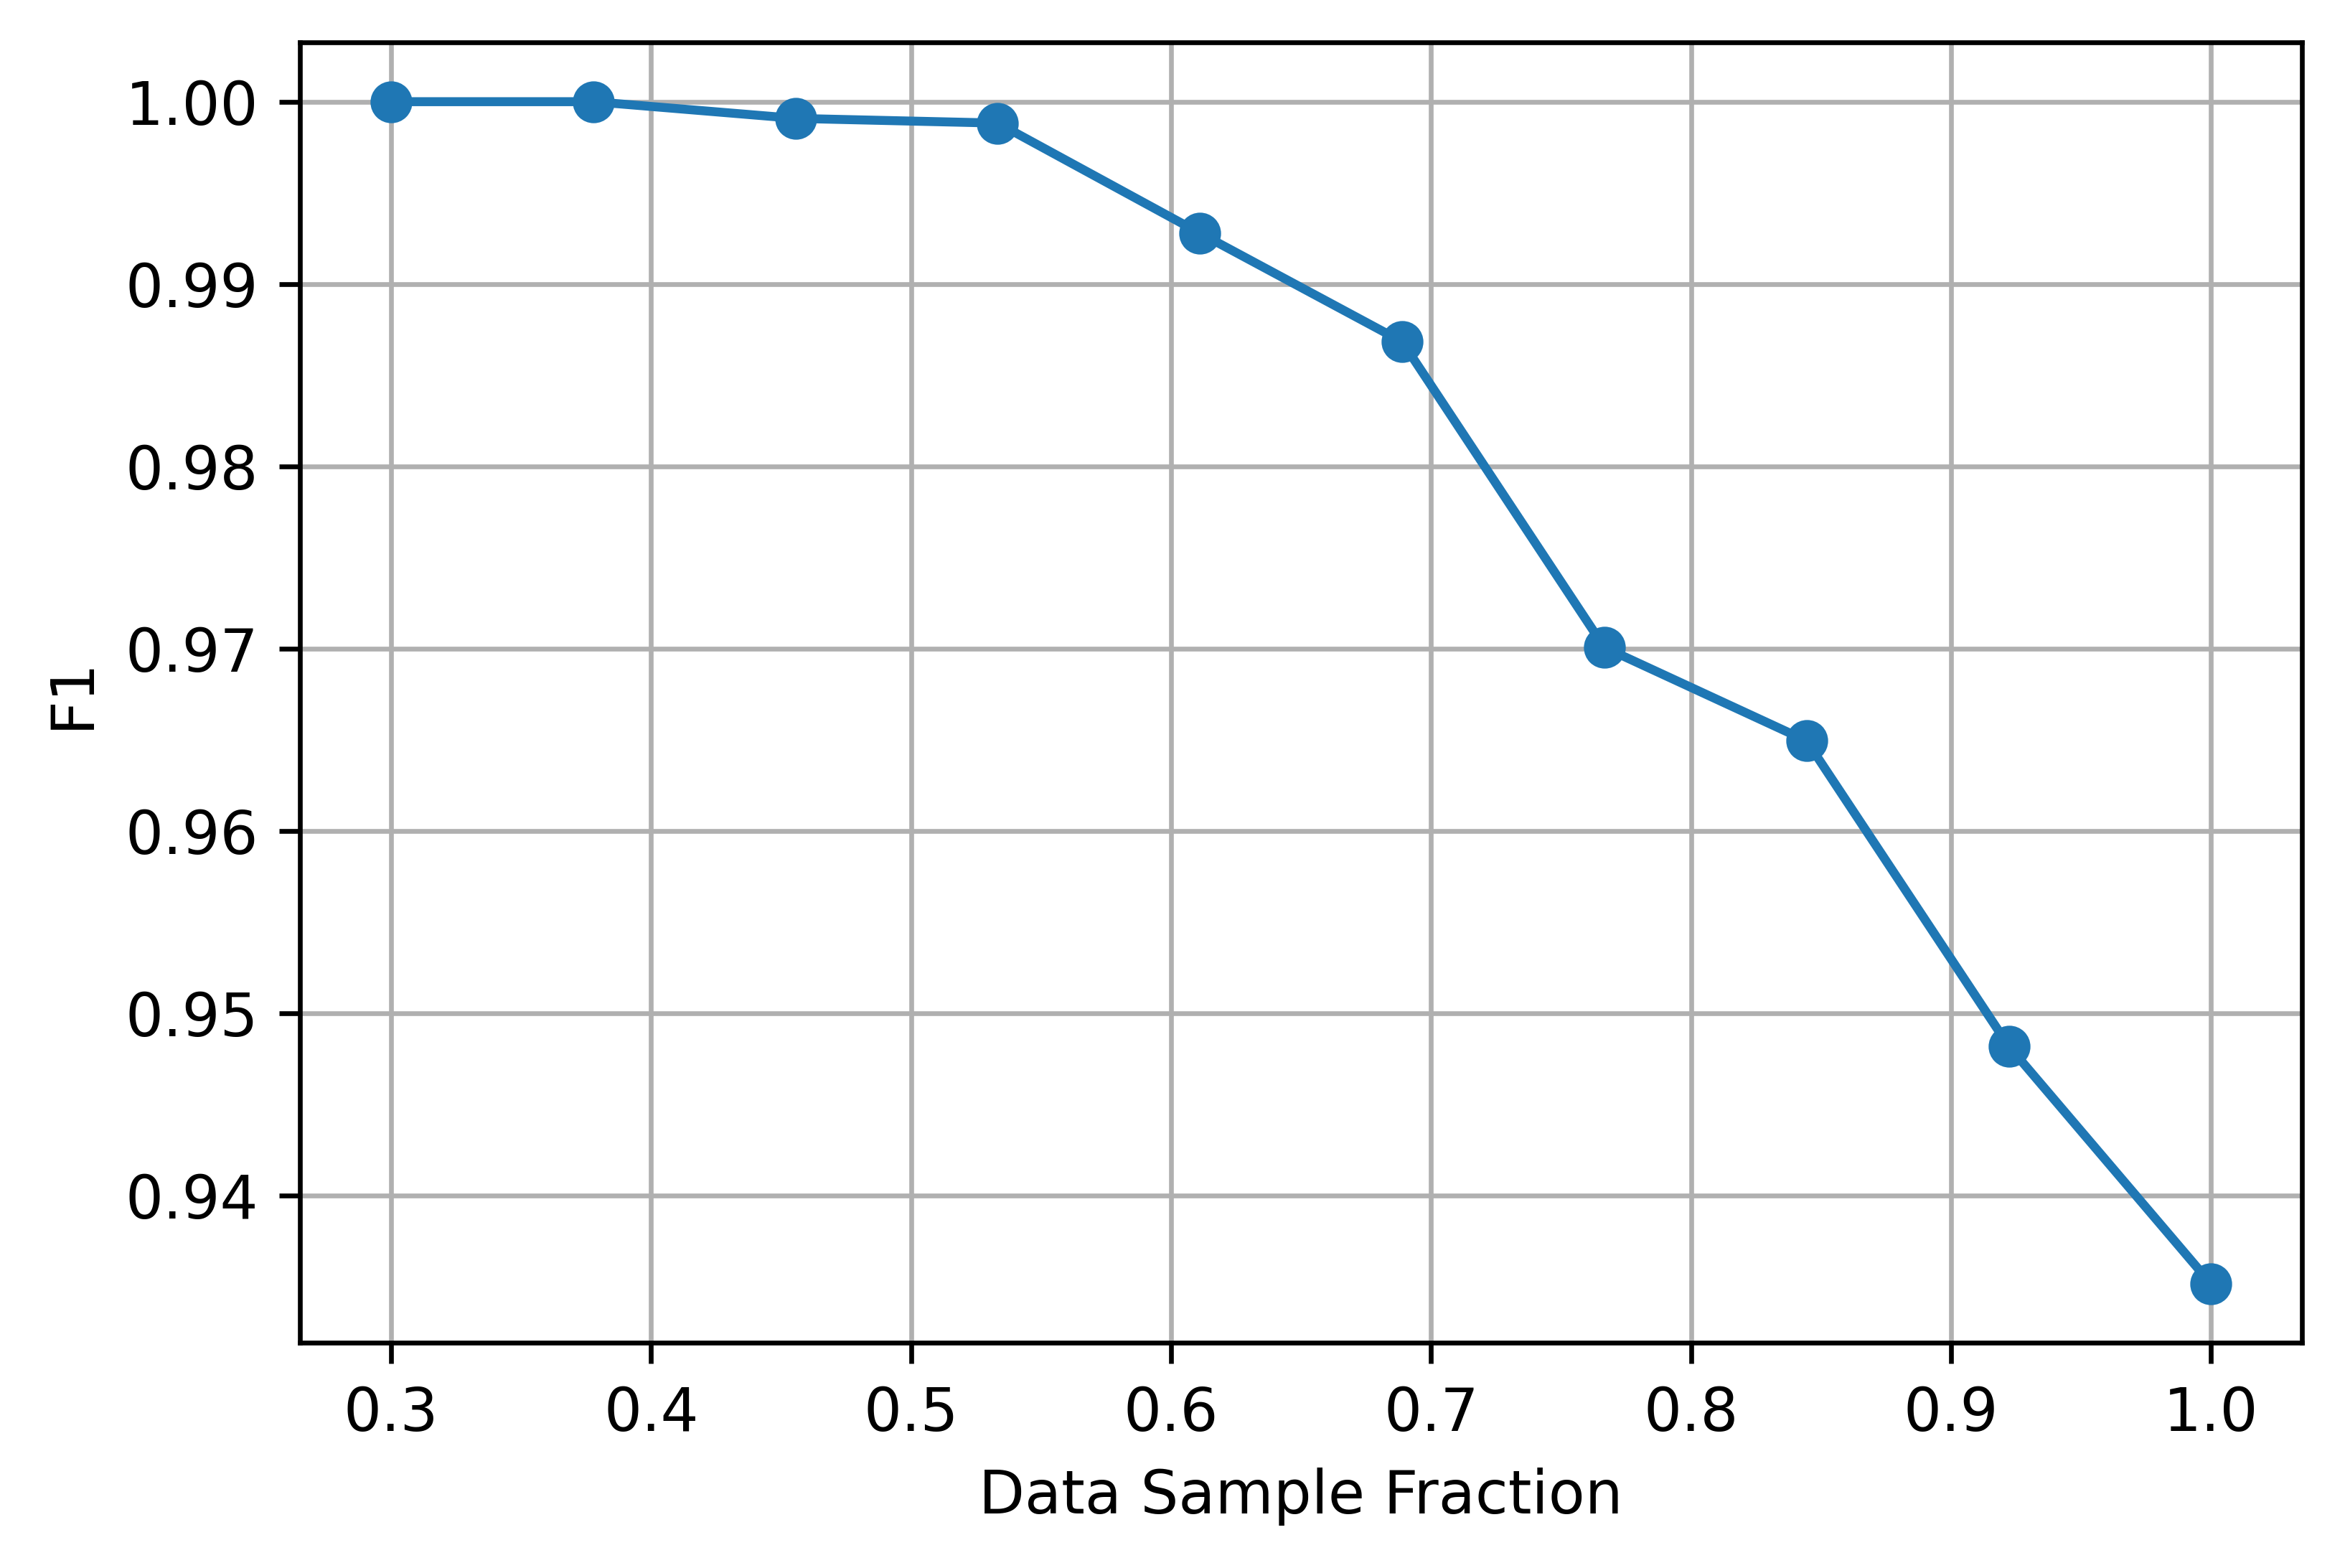

In [93]:
# Custom learning curve Catboost
from sklearn.metrics import f1_score
plt.figure(dpi=600)
plt.grid()
dist = np.linspace(0.3, 1.0, 10)
score_sets = []
params_lc = {
    'depth': 6,
    'iterations': 1000,
    'learning_rate': 0.2,
    'custom_loss': 'F1',
    'loss_function': 'MultiClass'
}
for frac in dist:
    X_subset = X.sample(frac=frac)
    y_subset = y.sample(frac=frac)
    clf_lc = CatBoostClassifier(**params_lc)
    clf_lc.fit(X_subset, y_subset)

    ypredict = clf_lc.predict(X_subset)
    f1_weighted_score=f1_score(y_subset, ypredict, average='weighted')
    score_sets.append(f1_weighted_score)

# Plot learningcurve catboost
plt.plot(dist,score_sets, marker='o')
plt.ylabel('F1')
plt.xlabel('Data Sample Fraction')
plt.savefig(os.path.join(model_dir, f"{ml_method}_learningcurve.png"))
plt.show()


Params are set to: {'depth': 3, 'iterations': 1000, 'learning_rate': 0.2, 'custom_loss': 'F1', 'loss_function': 'MultiClass'}
0:	learn: 0.9824770	total: 8.19ms	remaining: 8.18s
1:	learn: 0.7131189	total: 16.1ms	remaining: 8.04s
2:	learn: 0.5396586	total: 24.7ms	remaining: 8.2s
3:	learn: 0.4238082	total: 33.4ms	remaining: 8.32s
4:	learn: 0.3371020	total: 40.8ms	remaining: 8.13s
5:	learn: 0.2707393	total: 53.4ms	remaining: 8.85s
6:	learn: 0.2201580	total: 63.1ms	remaining: 8.96s
7:	learn: 0.1812989	total: 71.4ms	remaining: 8.86s
8:	learn: 0.1501564	total: 80.1ms	remaining: 8.82s
9:	learn: 0.1257871	total: 89.6ms	remaining: 8.87s
10:	learn: 0.1067257	total: 98.5ms	remaining: 8.86s
11:	learn: 0.0910314	total: 107ms	remaining: 8.81s
12:	learn: 0.0775876	total: 116ms	remaining: 8.82s
13:	learn: 0.0672546	total: 125ms	remaining: 8.78s
14:	learn: 0.0586526	total: 136ms	remaining: 8.94s
15:	learn: 0.0512782	total: 145ms	remaining: 8.91s
16:	learn: 0.0453044	total: 152ms	remaining: 8.81s
17:	lea

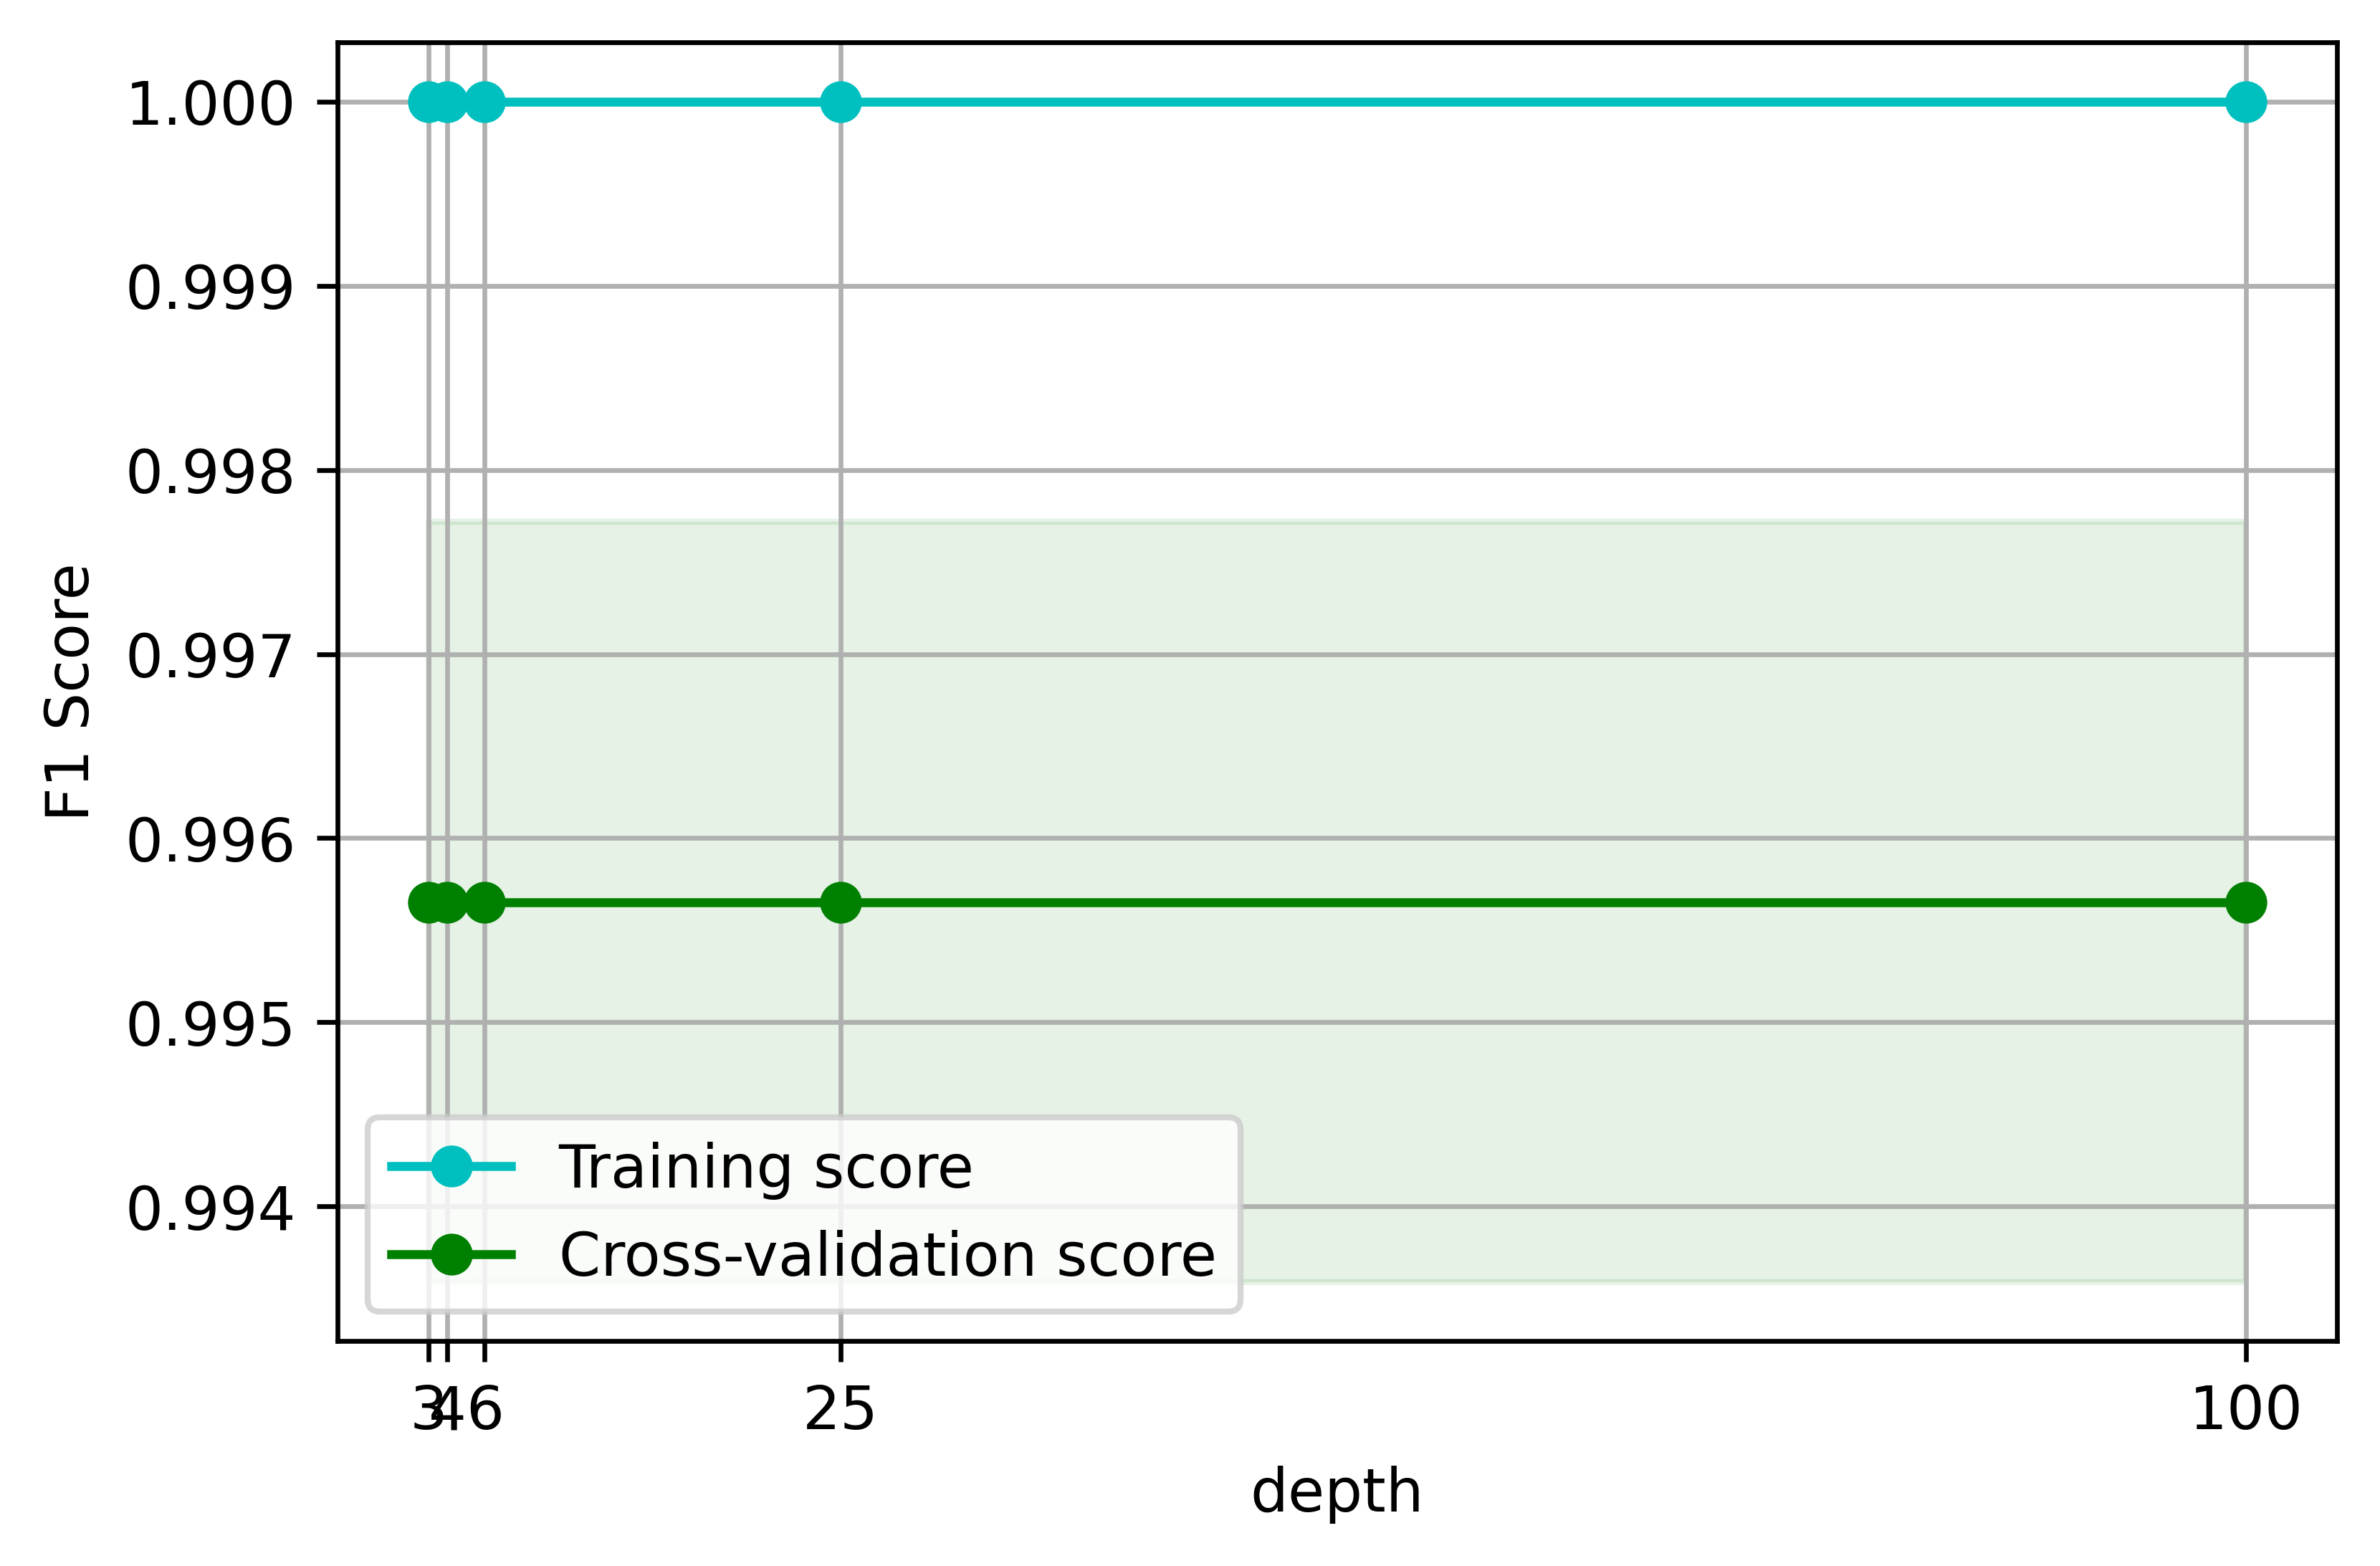

In [94]:
# Depth parameter
plt.figure(dpi=600)

param_range = [
    {"depth":3},
    {"depth":4},
    {"depth":6},
    {"depth":25},
    {"depth":100},
    ]

params = {
    'depth': 6,
    'iterations': 1000,
    'learning_rate': 0.2,
    'custom_loss': 'F1',
    'loss_function': 'MultiClass'
}

score_sets = []

np_train_scores = np.empty((0, sss.n_splits))
np_test_scores = np.empty((0, sss.n_splits))

# Get param name and values
param_values = []
param_name = list(param_range[0].keys())[0]
for d in param_range:
    param_values.append(list(d.values())[0])
param_labels = param_values

# Check if param values have string type
if any(isinstance(item, str) for item in param_values):
    len_param_values = len(param_values)
    param_values = list(range(0,len_param_values))

for param in param_range:
    params.update(param)
    print(f"Params are set to: {params}")
    cv_scores_train = []
    cv_scores_test = []

    fold=1
    for train_index, test_index in sss.split(X, y):
        Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
        ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
        clf = CatBoostClassifier(**params_lc)
        clf.fit(Xtrain, ytrain)

        ypredict = clf.predict(Xtrain)
        f1_weighted_score_train=f1_score(ytrain, ypredict, average='weighted')

        ypredict_test = clf.predict(Xtest)
        f1_weighted_score_test=f1_score(ytest, ypredict_test, average='weighted')
        cv_scores_test.append(f1_weighted_score_test)
        cv_scores_train.append(f1_weighted_score_train)

    np_train_scores = np.append(np_train_scores,[cv_scores_train], axis=0)
    np_test_scores = np.append(np_test_scores,[cv_scores_test], axis=0)

# Compute for fill_between plot
np_train_scores_mean = np.mean(np_train_scores, axis=1)
np_train_scores_std = np.std(np_train_scores, axis=1)
np_test_scores_mean = np.mean(np_test_scores, axis=1)
np_test_scores_std = np.std(np_test_scores, axis=1)

# Plot
plt.grid()
plt.fill_between(param_values, np_train_scores_mean - np_train_scores_std,
             np_train_scores_mean + np_train_scores_std, alpha=0.1,
             color="c")
plt.fill_between(param_values, np_test_scores_mean - np_test_scores_std,
             np_test_scores_mean + np_test_scores_std, alpha=0.1, color="g")
plt.plot(param_values, np_train_scores_mean, 'o-', color="c",
     label="Training score")
plt.plot(param_values, np_test_scores_mean, 'o-', color="g",
     label="Cross-validation score")

# Labels and legends
plt.xticks(ticks=param_values, labels=param_labels)
plt.ylabel("F1 Score")
plt.xlabel(param_name)
# plt.legend(loc='upper right')
plt.legend(loc="best")
plt.savefig(os.path.join(model_dir, f"{ml_method}_depth_learningcurve.png"))
plt.show()

Starting params: {'depth': 6, 'n_estimators': 10, 'learning_rate': 0.2, 'custom_loss': 'F1', 'loss_function': 'MultiClass'}
0:	learn: 0.9824770	total: 8.11ms	remaining: 73ms
1:	learn: 0.7131189	total: 17.1ms	remaining: 68.2ms
2:	learn: 0.5396586	total: 24.8ms	remaining: 58ms
3:	learn: 0.4238082	total: 35.6ms	remaining: 53.3ms
4:	learn: 0.3371020	total: 44.9ms	remaining: 44.9ms
5:	learn: 0.2707393	total: 52.9ms	remaining: 35.3ms
6:	learn: 0.2201580	total: 61.7ms	remaining: 26.5ms
7:	learn: 0.1812989	total: 69.6ms	remaining: 17.4ms
8:	learn: 0.1501564	total: 77.4ms	remaining: 8.6ms
9:	learn: 0.1257871	total: 84.2ms	remaining: 0us
0:	learn: 0.9831852	total: 7.51ms	remaining: 67.6ms
1:	learn: 0.7158906	total: 15.5ms	remaining: 61.8ms
2:	learn: 0.5445236	total: 23.1ms	remaining: 53.9ms
3:	learn: 0.4330277	total: 30.9ms	remaining: 46.3ms
4:	learn: 0.3447969	total: 39.1ms	remaining: 39.1ms
5:	learn: 0.2790966	total: 45.8ms	remaining: 30.5ms
6:	learn: 0.2271854	total: 54.4ms	remaining: 23.3ms


<Figure size 3600x2400 with 0 Axes>

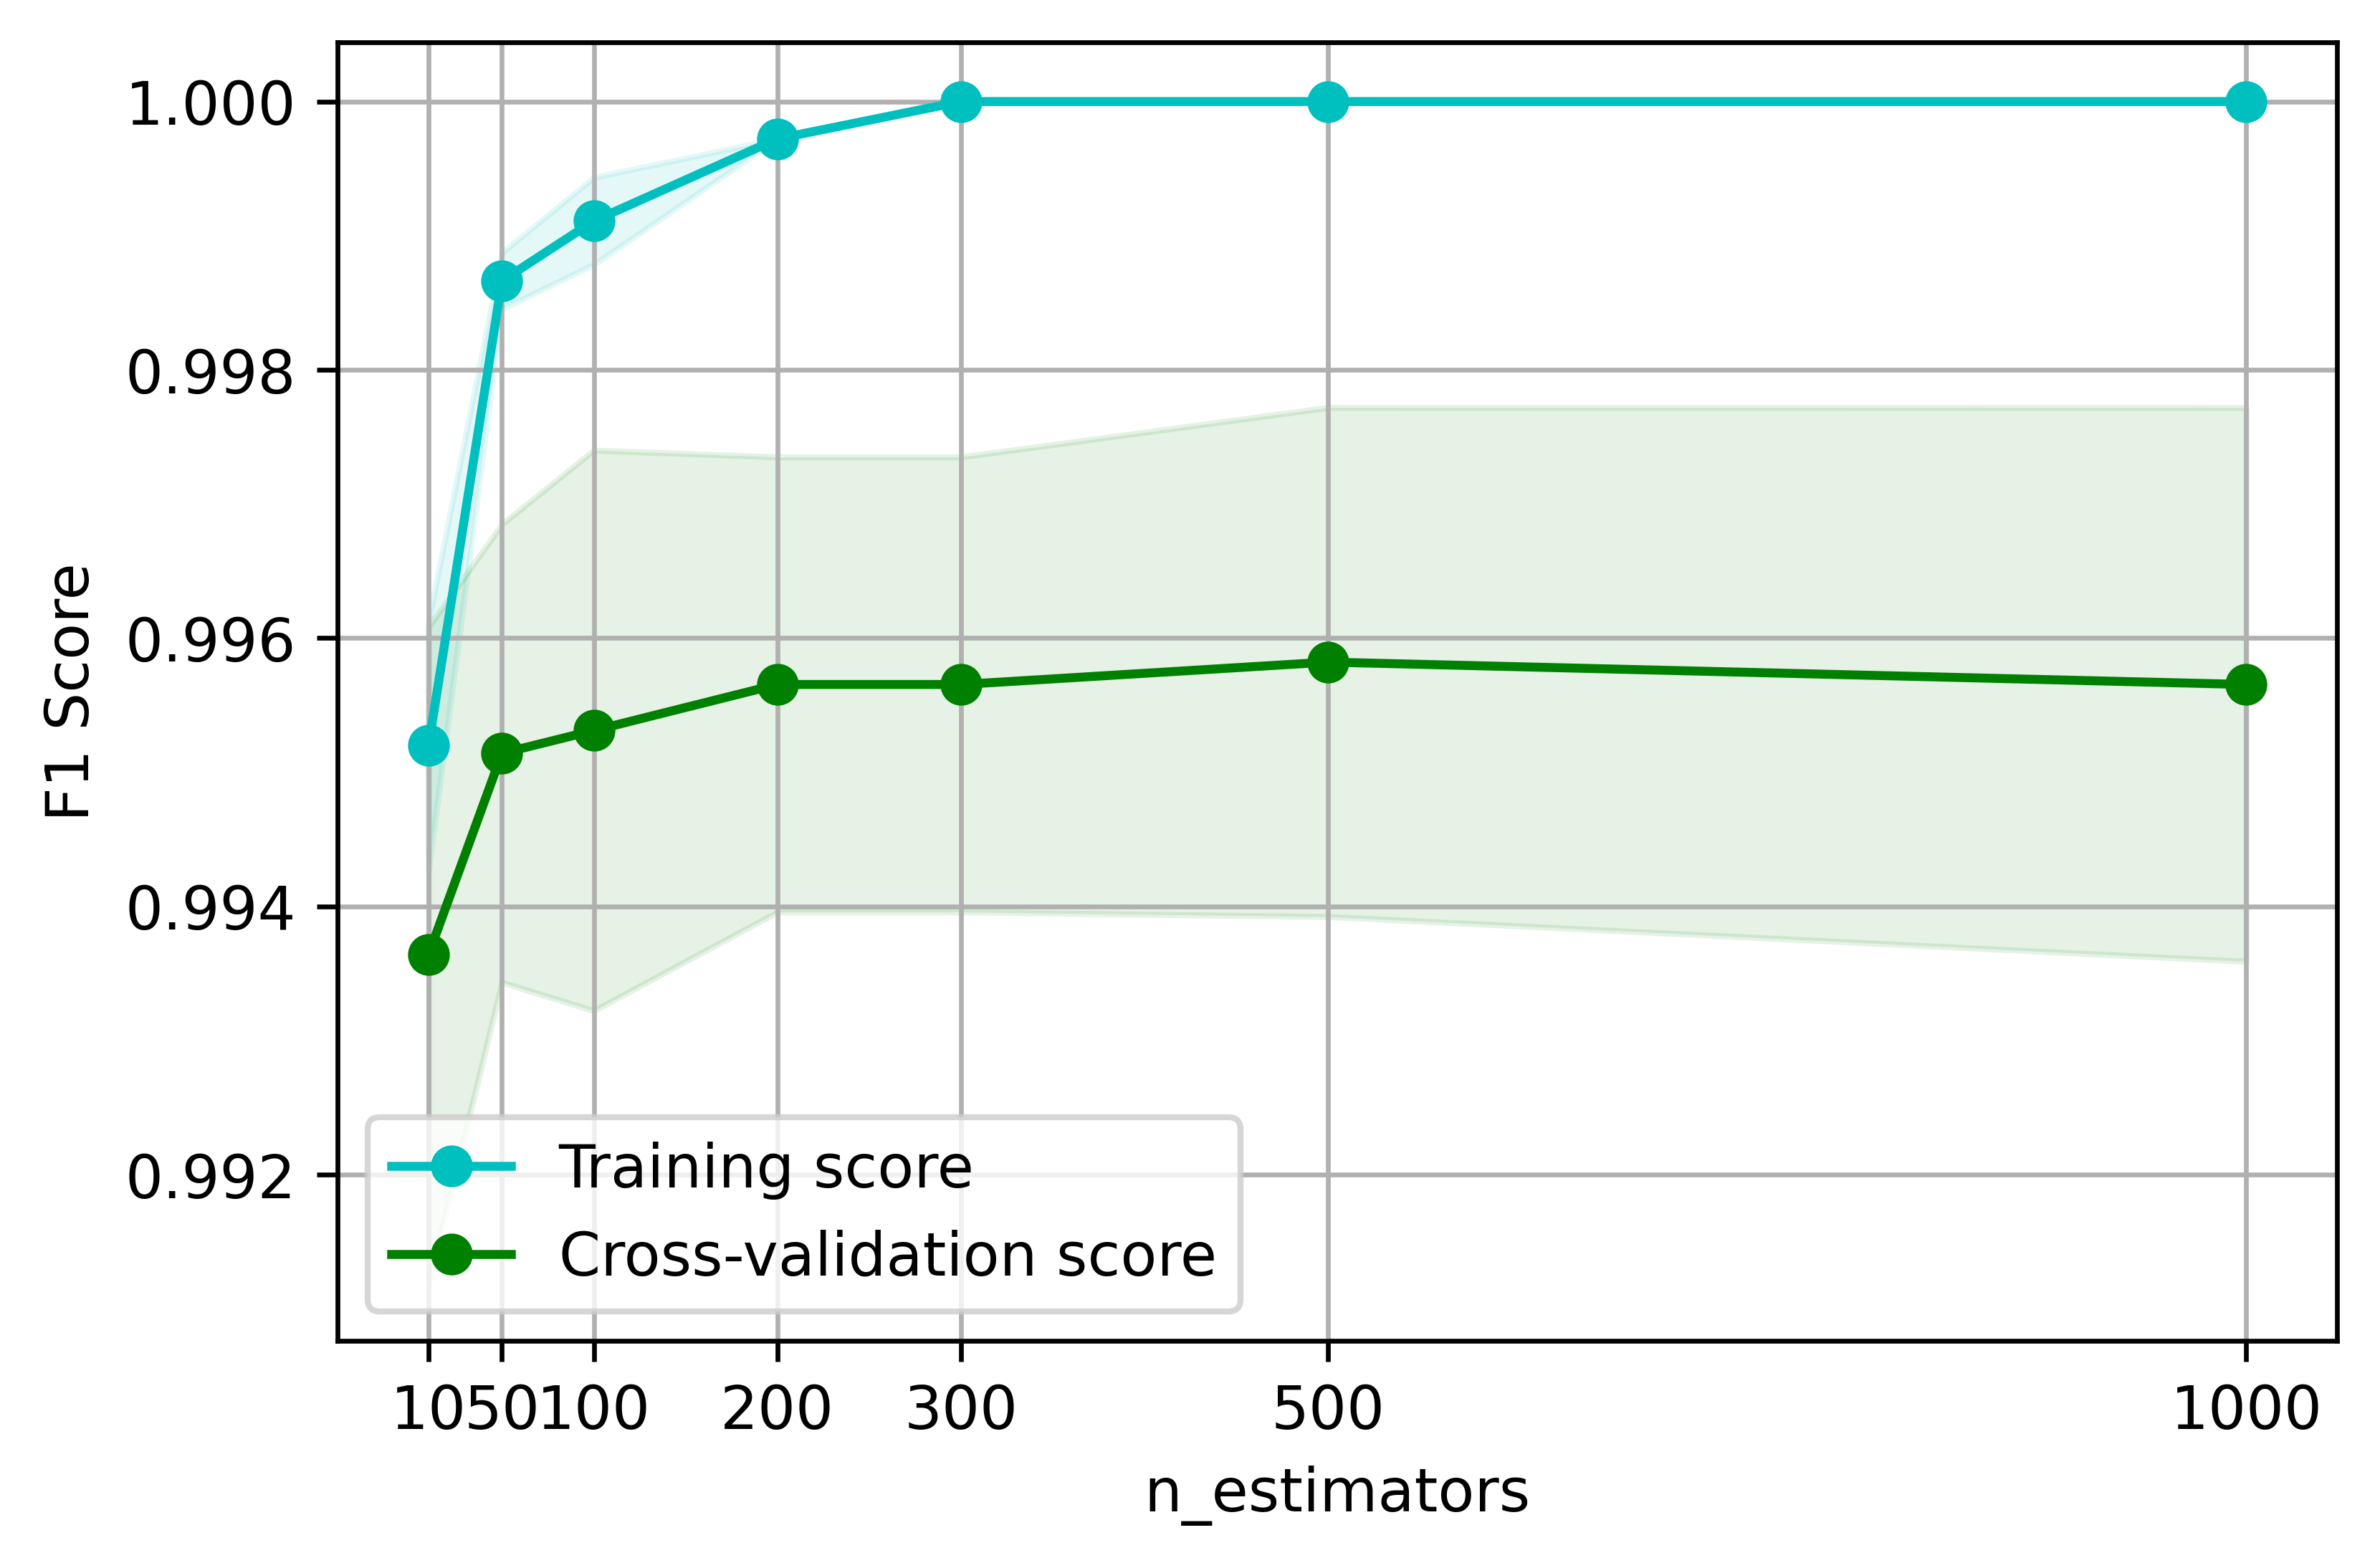

In [95]:
# Number of estimators
plt.figure(dpi=600)

param_range = [
    {"n_estimators":10},
    {"n_estimators":50},
    {"n_estimators":100},
    {"n_estimators":200},
    {"n_estimators":300},
    {"n_estimators":500},
    {"n_estimators":1000},
    ]

params = {
    'depth': 6,
    'n_estimators': 1000,
    'learning_rate': 0.2,
    'custom_loss': 'F1',
    'loss_function': 'MultiClass'
}


def param_learning_curve(X,
                         y,
                         params,
                         param_range,
                         ml_method,
                         label,
                         cv):
    """
    :param X: Dataset for training
    :param y: Ground Truth of training data
    :param params: dictionary of DNN params
    :param param_range: parameter range for dict
    :param ml_method: ml_method unique identifier
    :param cv: cross validation instance to be used

    :return:
    """
    plt.figure(dpi=600)

    np_train_scores = np.empty((0, sss.n_splits))
    np_test_scores = np.empty((0, sss.n_splits))

    # Get param name and values
    param_values = []
    param_name = list(param_range[0].keys())[0]
    for d in param_range:
        param_values.append(list(d.values())[0])
    param_labels = param_values

    # Check if param values have string type
    if any(isinstance(item, str) for item in param_values):
        len_param_values = len(param_values)
        param_values = list(range(0,len_param_values))


    for param in param_range:
        params.update(param)
        print(f"Starting params: {params}")
        cv_scores_train = []
        cv_scores_test = []

        fold=1
        for train_index, test_index in cv.split(X, y):
            Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
            ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
            clf_param = CatBoostClassifier(**params)
            clf_param.fit(Xtrain, ytrain)


            ypred = clf_param.predict(Xtrain)
            f1_weighted_score_train=f1_score(ytrain, ypred, average='weighted')

            ypredict_test = clf_param.predict(Xtest)
            f1_weighted_score_test=f1_score(ytest, ypredict_test, average='weighted')

            cv_scores_test.append(f1_weighted_score_test)
            cv_scores_train.append(f1_weighted_score_train)
            fold+=1
        np_train_scores = np.append(np_train_scores,[cv_scores_train], axis=0)
        np_test_scores = np.append(np_test_scores,[cv_scores_test], axis=0)

    # Compute for fill_between plot
    np_train_scores_mean = np.mean(np_train_scores, axis=1)
    np_train_scores_std = np.std(np_train_scores, axis=1)
    np_test_scores_mean = np.mean(np_test_scores, axis=1)
    np_test_scores_std = np.std(np_test_scores, axis=1)


   # Plot
    plt.grid()
    plt.fill_between(param_values, np_train_scores_mean - np_train_scores_std,
                 np_train_scores_mean + np_train_scores_std, alpha=0.1,
                 color="c")
    plt.fill_between(param_values, np_test_scores_mean - np_test_scores_std,
                 np_test_scores_mean + np_test_scores_std, alpha=0.1, color="g")
    plt.plot(param_values, np_train_scores_mean, 'o-', color="c",
         label="Training score")
    plt.plot(param_values, np_test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

    # Labels and legends
    plt.xticks(ticks=param_values, labels=param_labels)
    plt.ylabel("F1 Score")
    plt.xlabel(param_name)
    # plt.legend(loc='upper right')
    plt.legend(loc="best")
    plt.savefig(os.path.join(model_dir, f"{ml_method}_{label}_learningcurve.png"))
    plt.show()

param_learning_curve(X, y, params, param_range, ml_method, label="estimators", cv=sss)

Starting params: {'depth': 6, 'n_estimators': 1000, 'learning_rate': 0.001, 'custom_loss': 'F1', 'loss_function': 'MultiClass'}
0:	learn: 1.6059066	total: 6.45ms	remaining: 6.44s
1:	learn: 1.6023040	total: 13.1ms	remaining: 6.52s
2:	learn: 1.5986607	total: 21ms	remaining: 6.97s
3:	learn: 1.5950830	total: 29.6ms	remaining: 7.38s
4:	learn: 1.5914365	total: 37.5ms	remaining: 7.45s
5:	learn: 1.5879226	total: 45.3ms	remaining: 7.5s
6:	learn: 1.5843880	total: 53ms	remaining: 7.51s
7:	learn: 1.5810073	total: 61ms	remaining: 7.56s
8:	learn: 1.5776037	total: 69.5ms	remaining: 7.65s
9:	learn: 1.5741011	total: 77.4ms	remaining: 7.66s
10:	learn: 1.5707771	total: 85.4ms	remaining: 7.67s
11:	learn: 1.5672399	total: 94ms	remaining: 7.74s
12:	learn: 1.5639942	total: 103ms	remaining: 7.8s
13:	learn: 1.5607666	total: 111ms	remaining: 7.83s
14:	learn: 1.5573473	total: 120ms	remaining: 7.85s
15:	learn: 1.5541116	total: 127ms	remaining: 7.83s
16:	learn: 1.5508457	total: 134ms	remaining: 7.78s
17:	learn: 1.

<Figure size 3600x2400 with 0 Axes>

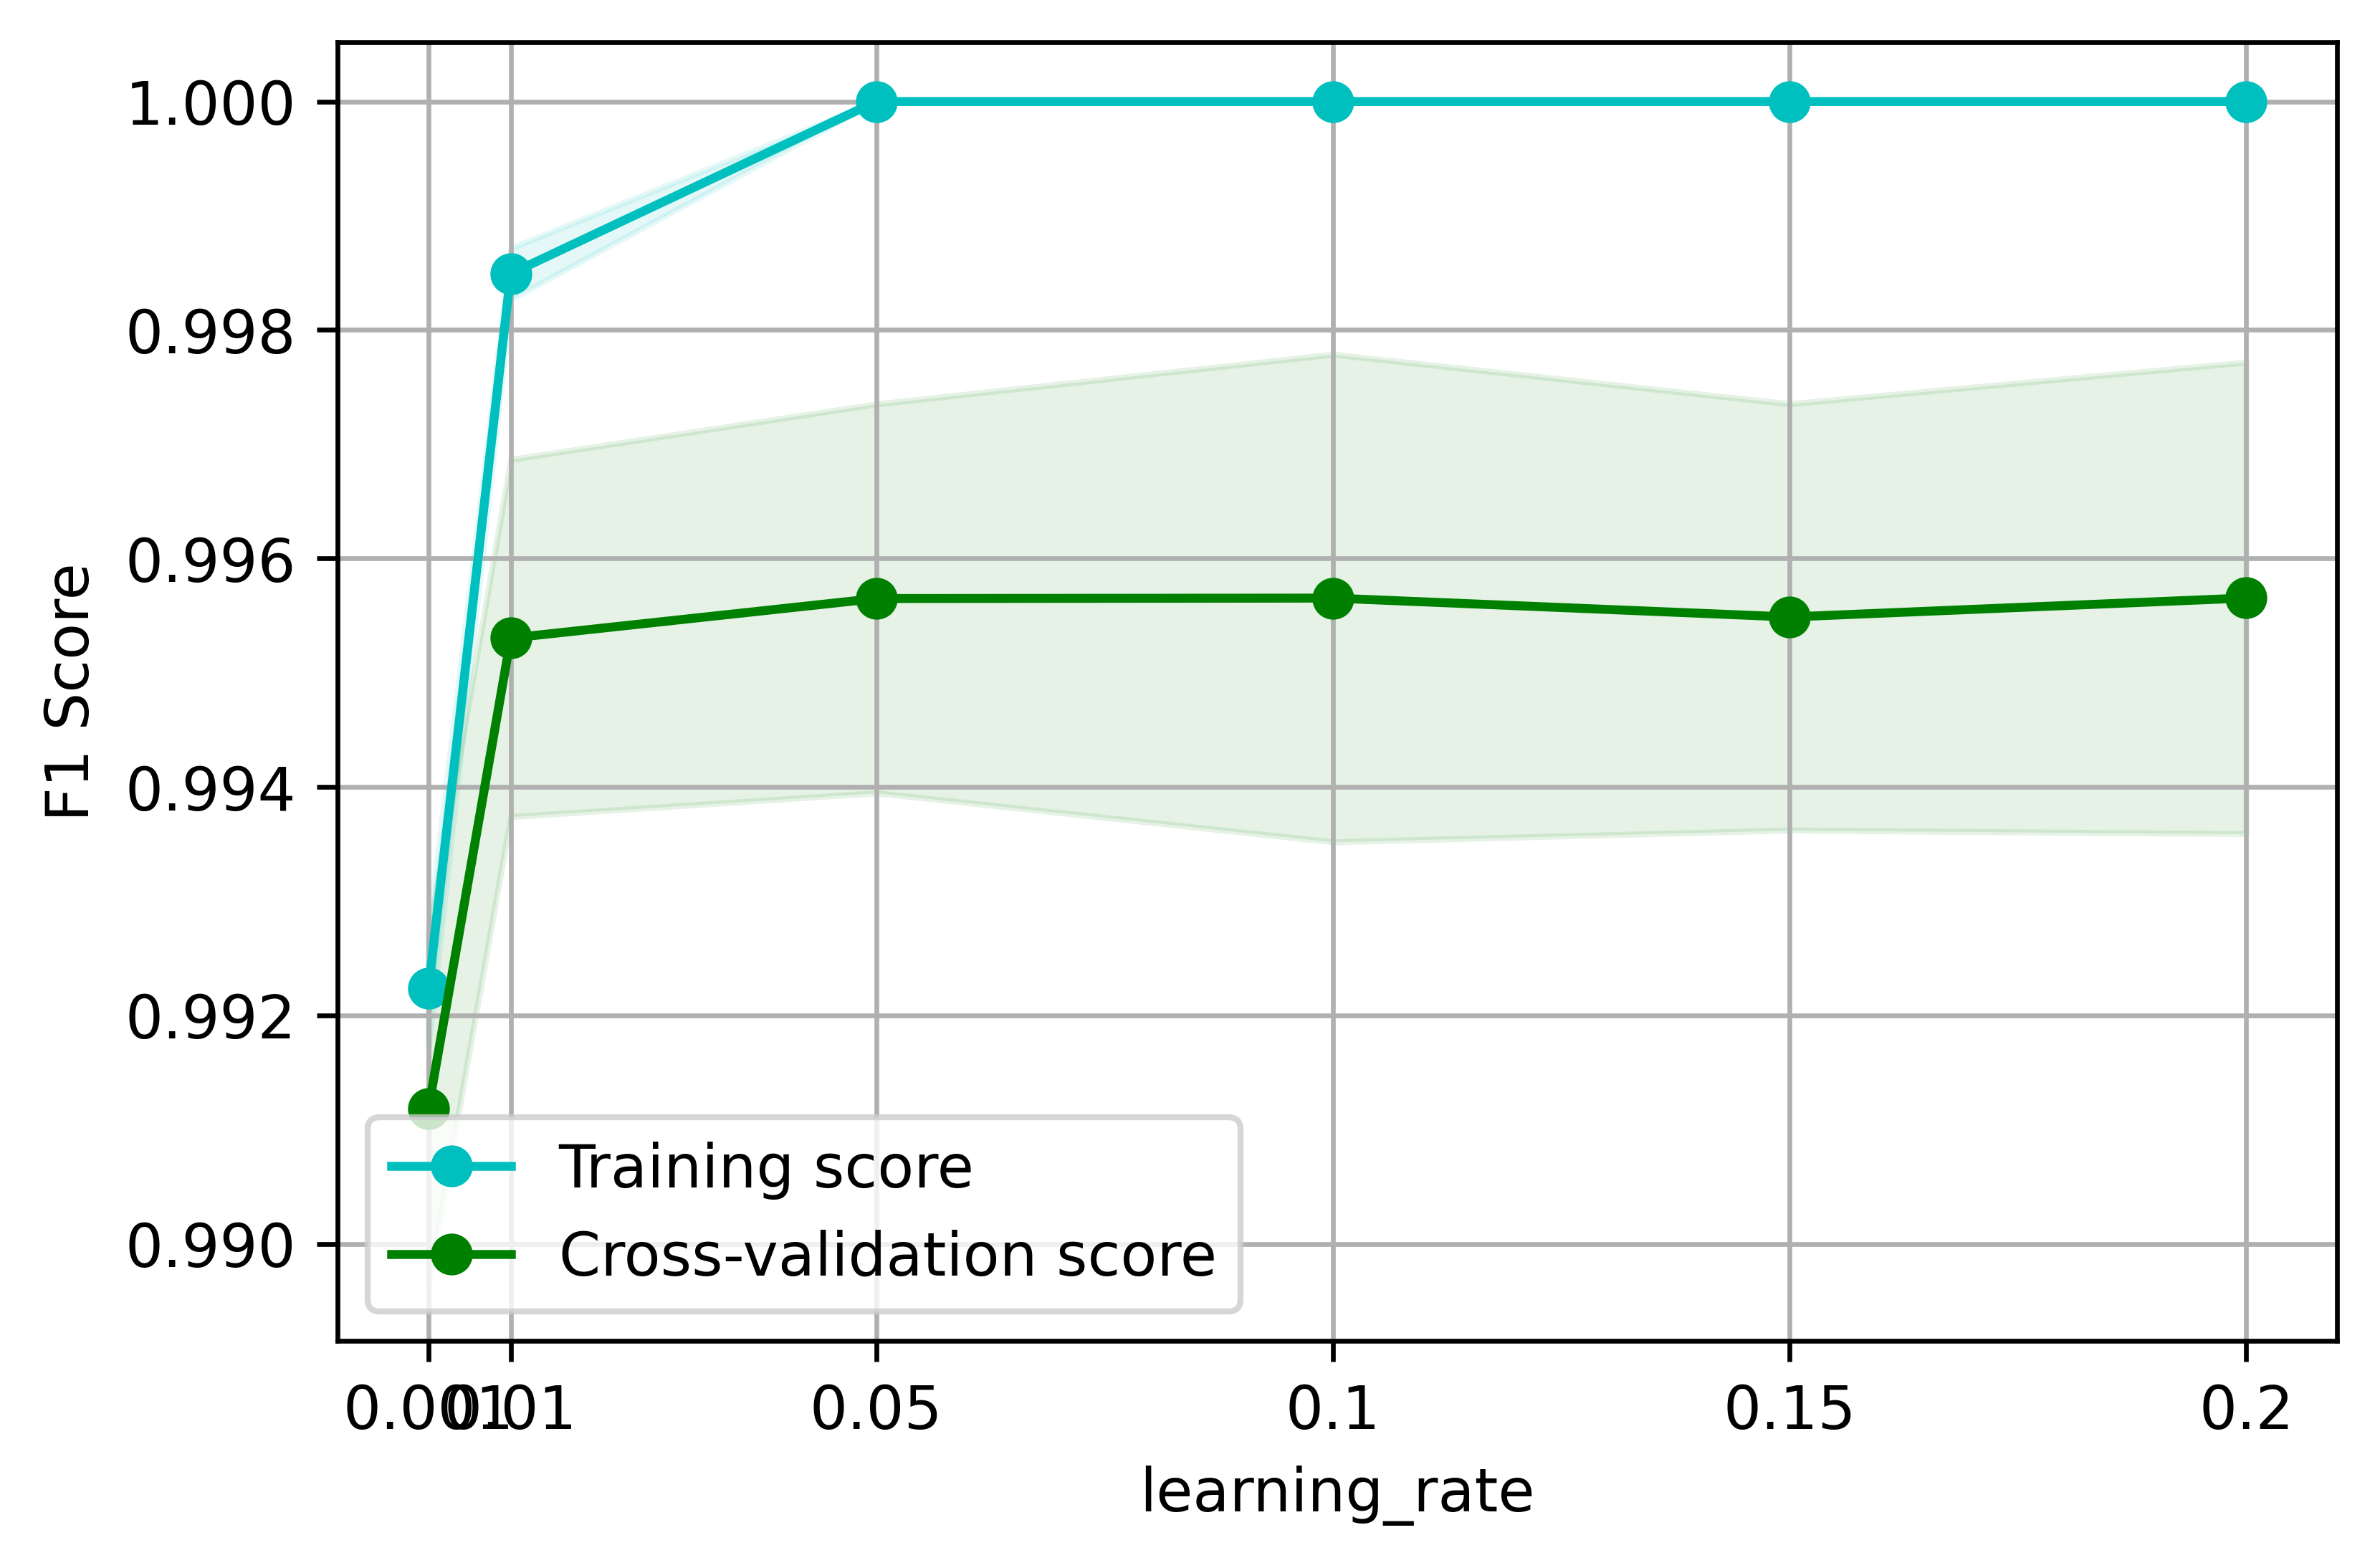

In [96]:
# Number of estimators
plt.figure(dpi=600)

param_range = [
    {"learning_rate":0.001},
    {"learning_rate":0.01},
    {"learning_rate":0.05},
    {"learning_rate":0.1},
    {"learning_rate":0.15},
    {"learning_rate":0.2},
    ]

params = {
    'depth': 6,
    'n_estimators': 1000,
    'learning_rate': 0.2,
    'custom_loss': 'F1',
    'loss_function': 'MultiClass'
}

param_learning_curve(X, y, params, param_range, ml_method, label="learning_rate",cv=sss)

In [97]:
# Get ROC curve direct from catboost

# params = {
#     'depth': 6,
#     'n_estimators': 1000,
#     'learning_rate': 0.2,
#     'custom_loss': 'F1',
# #     'loss_function': 'MultiClass'
# }
#
# clf_roc = CatBoostClassifier(**params)
# catboost_pool = Pool(X, y)
# clf_roc.fit(X, y)
#
# (fpr, tpr, thresholds) = get_roc_curve(clf_roc, catboost_pool, plot=True)
# print(fpr)
# print(tpr)
# print(thresholds)

In [98]:
# ROC AUC Curve using OnevRest scikit wrapper
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MultiLabelBinarizer

params = {
    'depth': 6,
    'n_estimators': 1000,
    'learning_rate': 0.2,
    'custom_loss': 'F1',
#     'loss_function': 'MultiClass'
}
# mlb = MultiLabelBinarizer()
# mlb.fit(y)
# y_oh_cat =  mlb.transform(y)


n_classes = len(y.unique())

y_oh_cat = np.asarray(pd.get_dummies(y))
clf_ovr = OneVsRestClassifier(estimator=CatBoostClassifier(**params))
clf_ovr.fit(X, y_oh_cat)
y_score = clf_ovr.predict_proba(X)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_oh_cat[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_oh_cat.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

0:	learn: 0.2901950	total: 5.59ms	remaining: 5.58s
1:	learn: 0.1191299	total: 11.5ms	remaining: 5.72s
2:	learn: 0.0558895	total: 16.8ms	remaining: 5.59s
3:	learn: 0.0327815	total: 21.2ms	remaining: 5.28s
4:	learn: 0.0199996	total: 25.6ms	remaining: 5.09s
5:	learn: 0.0157687	total: 29.7ms	remaining: 4.92s
6:	learn: 0.0133570	total: 33.8ms	remaining: 4.8s
7:	learn: 0.0121959	total: 37.9ms	remaining: 4.7s
8:	learn: 0.0110950	total: 41.6ms	remaining: 4.58s
9:	learn: 0.0094282	total: 45.8ms	remaining: 4.54s
10:	learn: 0.0086106	total: 51.2ms	remaining: 4.6s
11:	learn: 0.0083814	total: 56.4ms	remaining: 4.64s
12:	learn: 0.0077885	total: 61.7ms	remaining: 4.68s
13:	learn: 0.0072732	total: 65.1ms	remaining: 4.58s
14:	learn: 0.0070955	total: 68.7ms	remaining: 4.51s
15:	learn: 0.0068338	total: 73.9ms	remaining: 4.54s
16:	learn: 0.0067004	total: 79ms	remaining: 4.57s
17:	learn: 0.0060630	total: 83.2ms	remaining: 4.54s
18:	learn: 0.0058902	total: 87.9ms	remaining: 4.54s
19:	learn: 0.0053927	total:

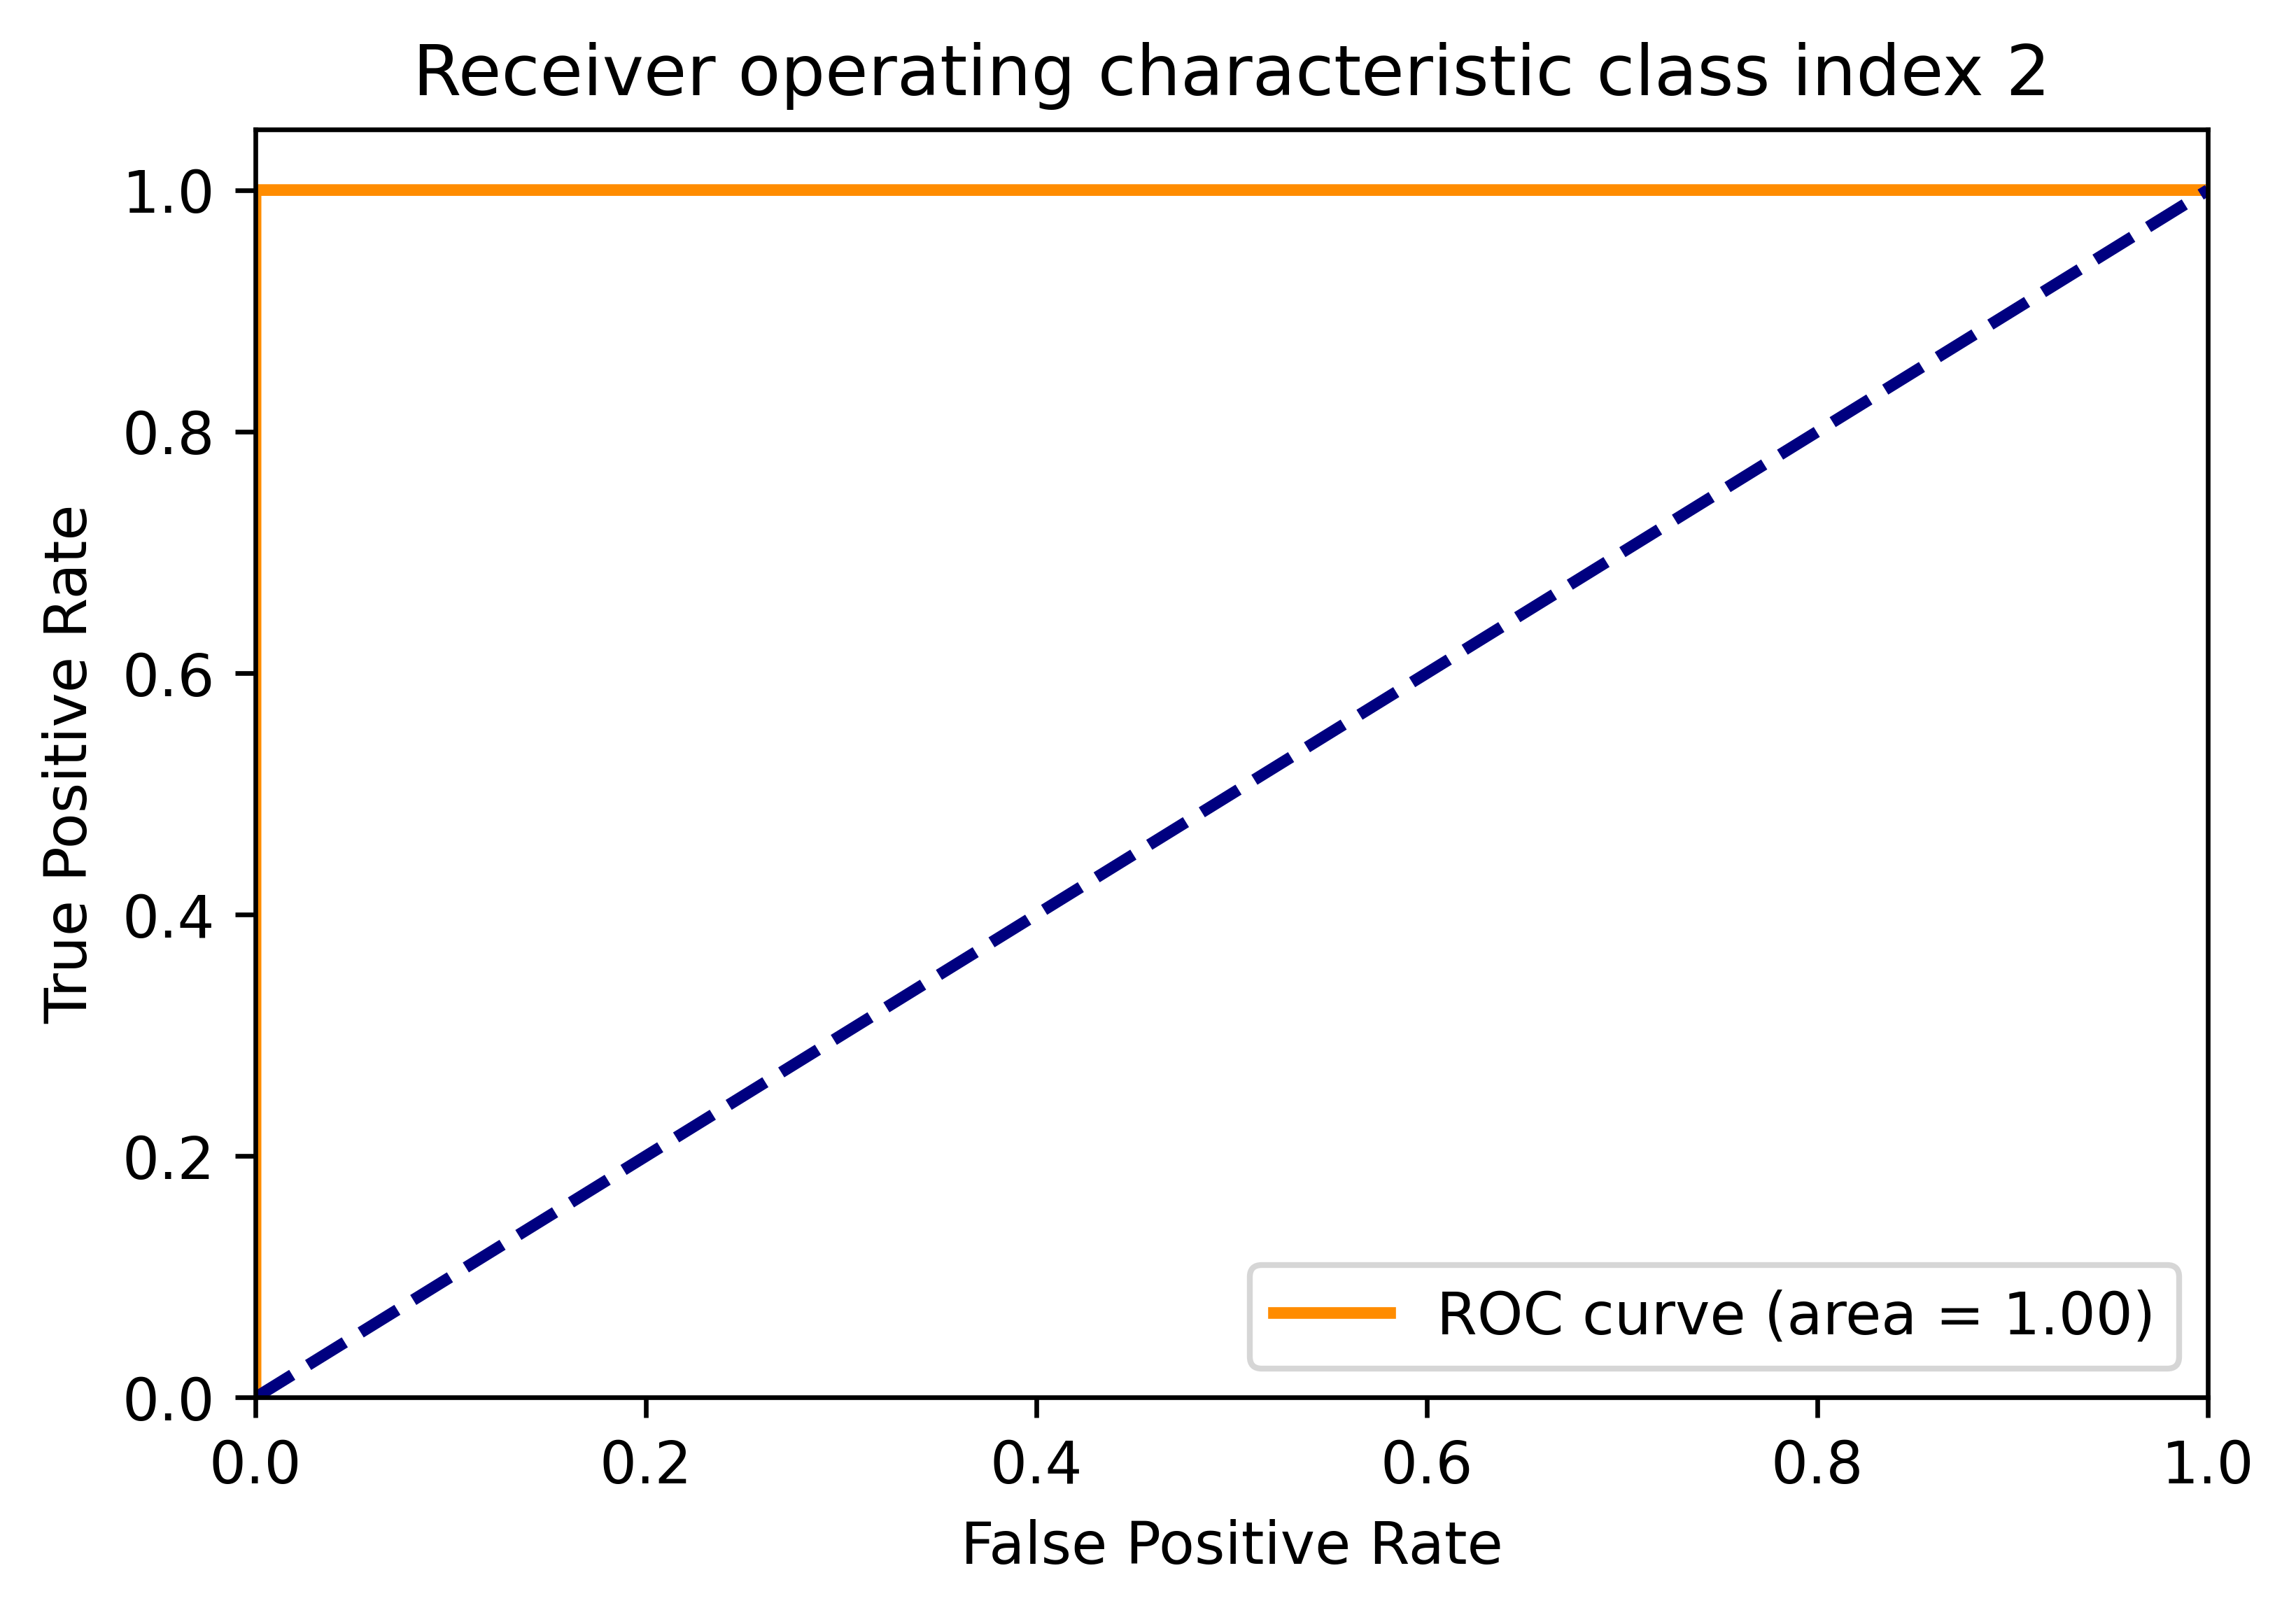

In [99]:
# ROC curve for a specific class
plt.figure(dpi=600) #For publication only
lw = 2
class_i = 2
plt.plot(
    fpr[class_i],
    tpr[class_i],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Receiver operating characteristic class index {class_i}")
plt.legend(loc="lower right")
plt.show()

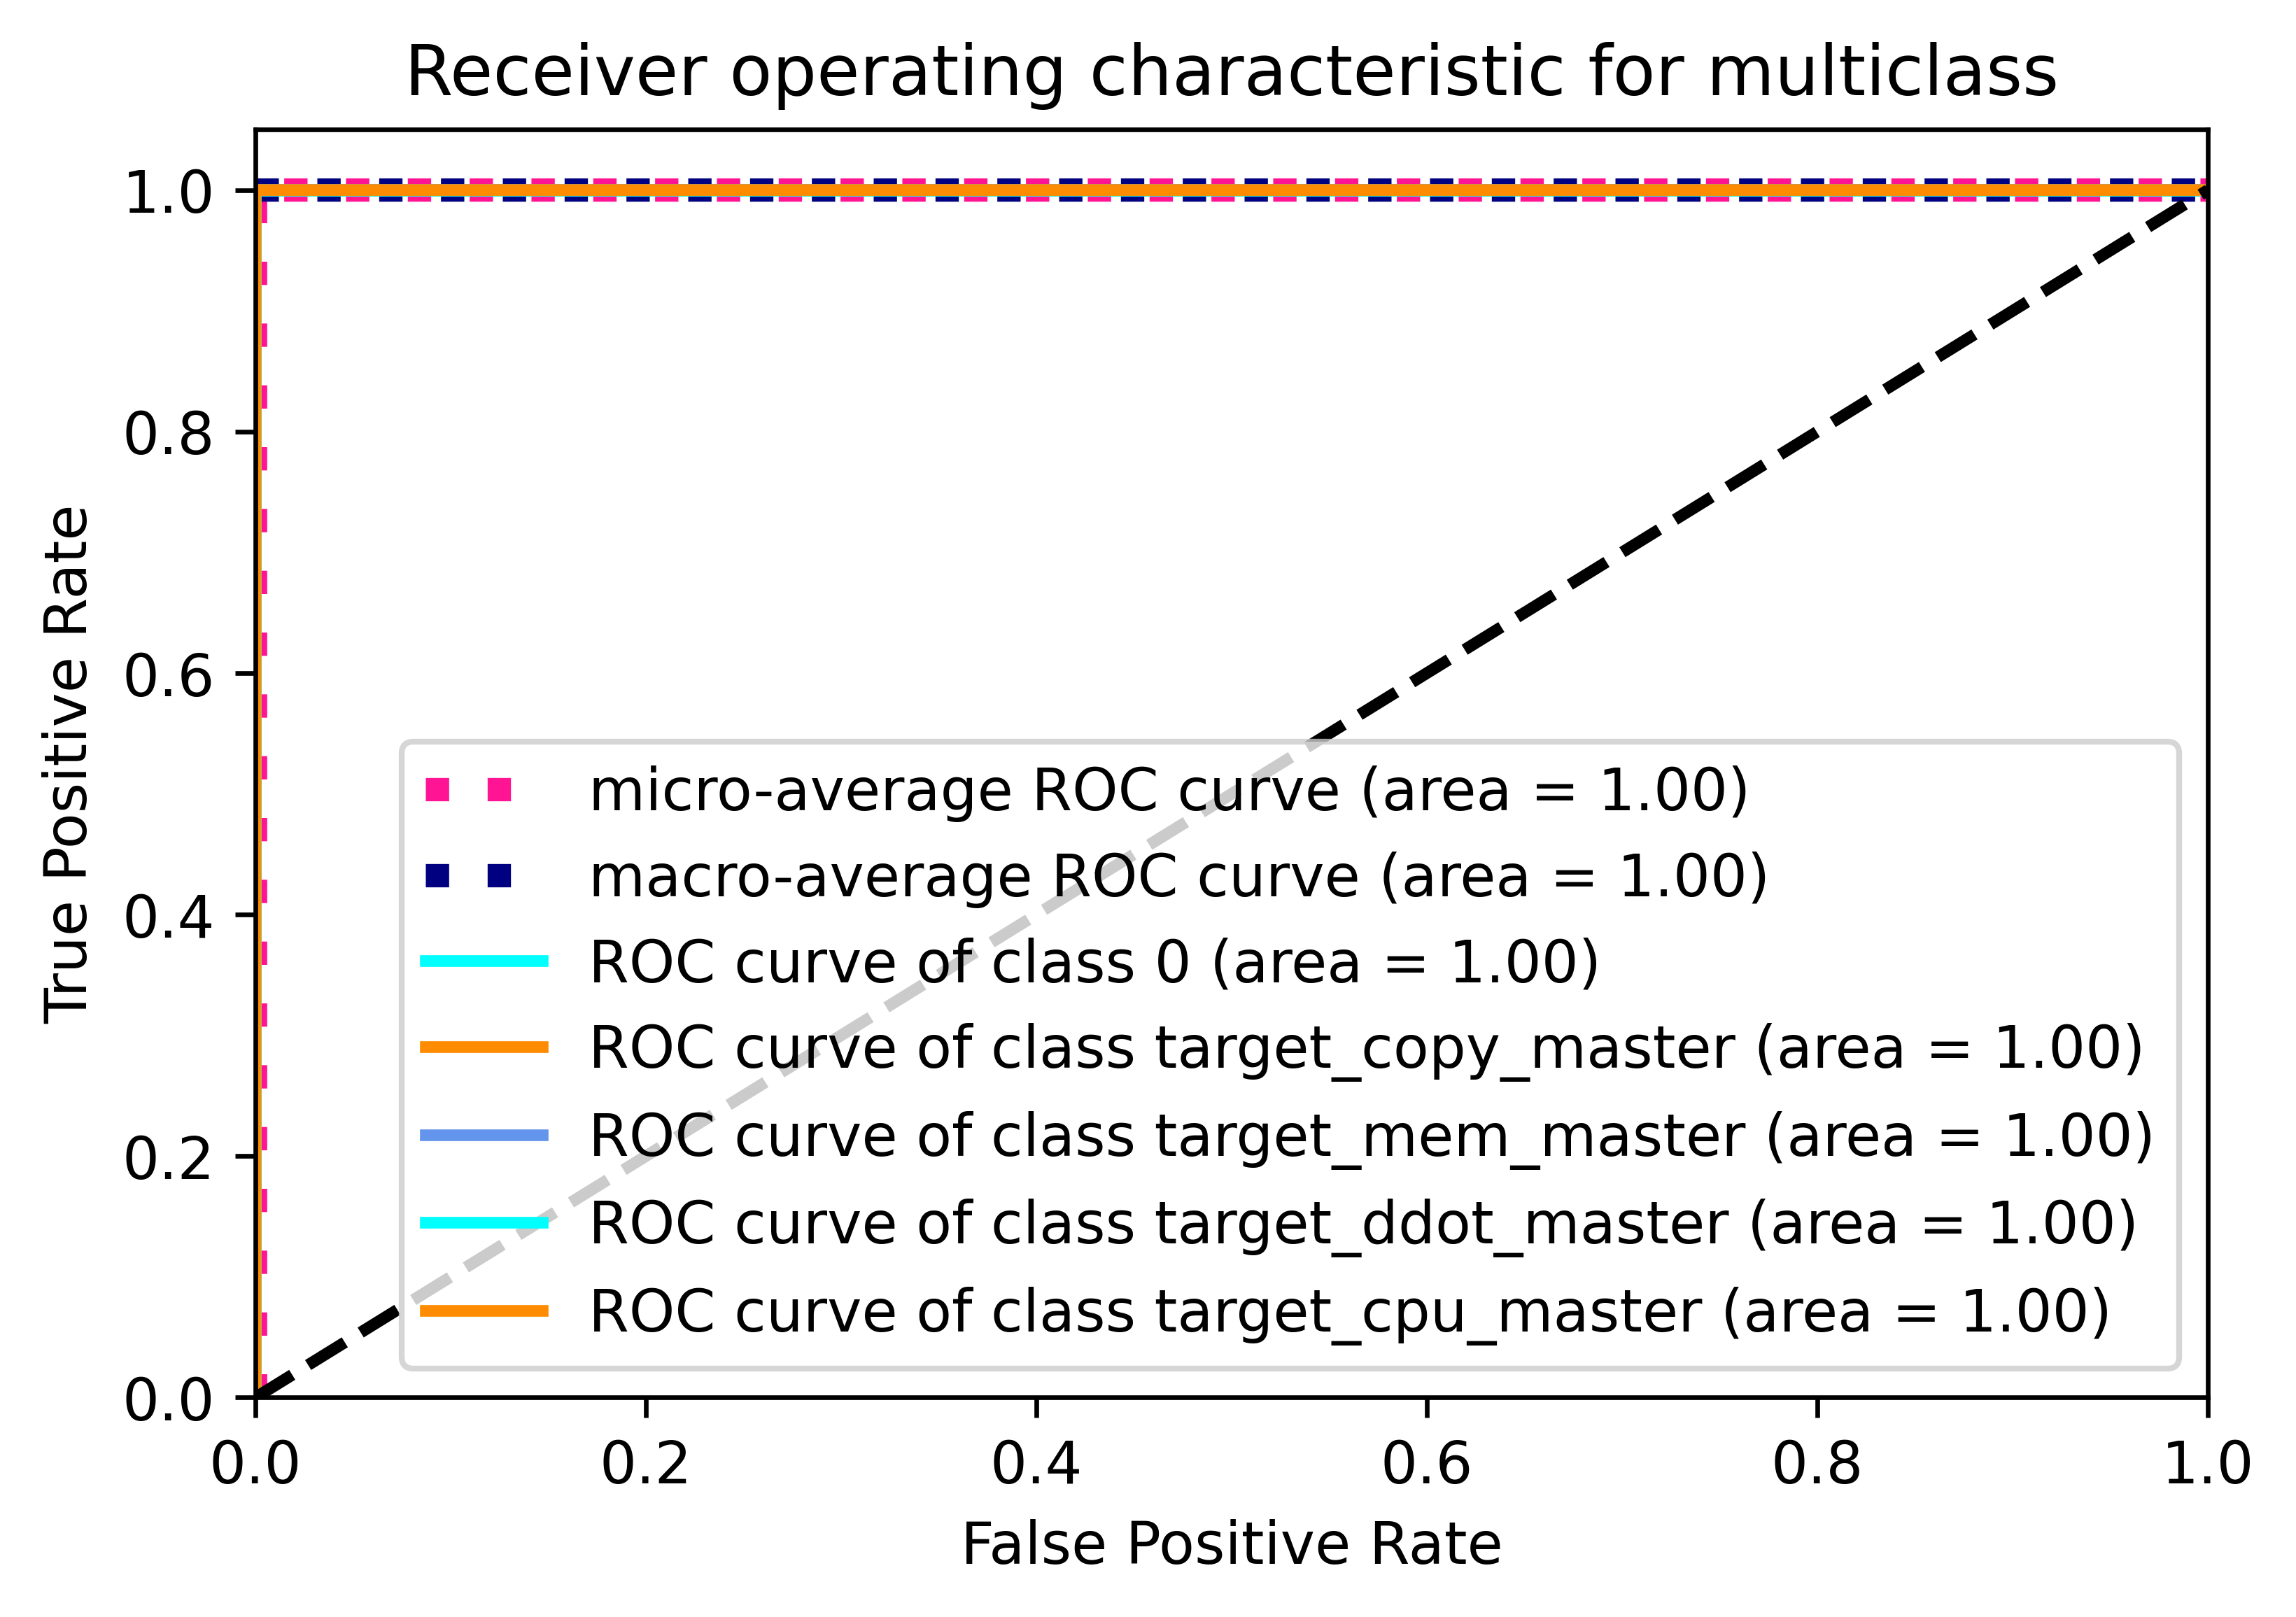

In [100]:
# First aggregate all false positive rates
from itertools import cycle
plt.figure(dpi=600) #For publication only
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(definitions[i], roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic for multiclass")
plt.legend(loc="lower right")
plt.savefig(os.path.join(model_dir, f"{ml_method}_ROCAUC.png"))
plt.show()

Scoring on holdout or other dataset

In [101]:
def compare_to_holdout(df_data,
                       model,
                       definitions,
                       scaler=None,
                       clean=False,
                       prefix='rf_holdout'):
    #Creating the dependent variable class
    factor_h = pd.factorize(df_data['target'])
    df_data.target = factor_h[0]
    definitions_test_data = factor_h[1]
    print("Splitting dataset into data and ground truth ...")
    X_h = df_data.drop('target', axis=1)
    y_h = df_data['target']
    # Scale same as original dataset
    if scaler is None:
        scaler = MinMaxScaler()
    X_h = scaler.fit_transform(X_h)  # scaler only used on a per fold basis may cause error on entire dataset.
    # Select model from split to be tested
    y_pred_h = model.predict(X_h)


    # Recompute custom definitions in case of mismath
    if len(list(np.unique(y_pred_h))) != len(definitions) and clean:
        print(f"Prediction contains the following classes: {list(np.unique(y_pred_h))}")
        target_names = []
        for t in list(np.unique(y_pred_h)):
            target_names.append(definitions[t])
        print(f"Mapped to: {target_names}")
    else:
        target_names = definitions
    # print(classification_report(y_h, y_pred_h, target_names=target_names))
    # print(classification_report(y_h, y_pred_h, target_names=target_names))
    # print(classification_report_imbalanced(y_h, y_pred_h), target_names=list(np.unique(y_pred_h)))
    custom_scoring_reporting(y_pred_h, y_h, definitions=target_names, prefix=prefix)

    print(f"Instances predicted by class:")
    print(f"{df_data}")
    if clean:
        cls, count =  np.unique(y_pred_h, return_counts=True)
    else:
        count = np.bincount(y_pred_h)
    print(pd.DataFrame({"Classes": target_names, "Predictions": count}))


    print("Generating confusion matrix for holdout")
    cf_matrix = confusion_matrix(y_h, y_pred_h)
    # plt.figure(figsize=(10,20), dpi=600) For publication only
    ht_cf=sns.heatmap(cf_matrix, annot=True, yticklabels=list(target_names), xticklabels=list(target_names))
    plt.title('Confusion Matrix Holdout set', fontsize = 15) # title with fontsize 20
    plt.xlabel('Ground Truth', fontsize = 10) # x-axis label with fontsize 15
    plt.ylabel('Predictions', fontsize = 10) # y-axis label with fontsize 15
    cf_fig = "CM_{}_{}.png".format(ml_method, prefix)
    ht_cf.figure.savefig(os.path.join(model_dir, cf_fig))
    plt.show()
    return y_pred_h, y_h.values, target_names

In [102]:
prefix_name = "catboost_holdout"

y_pred_h, y_h , target_names = compare_to_holdout(df_audsome,  clf_models[0], definitions=definitions, clean=False, prefix=prefix_name)

Splitting dataset into data and ground truth ...
Accuracy score is: 0.9989583333333333
Ballanced accuracy score is: 0.9956604440618104
Jaccard score (micro): 0.9979188345473465
Jaccard score (macro): 0.9936803468686752
Jaccard score (weighted): 0.9979228545567783
Full classification report
                    precision    recall  f1-score   support

                 0       1.00      1.00      1.00      3803
target_copy_master       1.00      1.00      1.00       269
 target_mem_master       1.00      1.00      1.00       268
target_ddot_master       0.99      1.00      1.00       317
 target_cpu_master       1.00      0.99      0.99       143

          accuracy                           1.00      4800
         macro avg       1.00      1.00      1.00      4800
      weighted avg       1.00      1.00      1.00      4800

Imbalanced Classification report
                          pre       rec       spe        f1       geo       iba       sup

                 0       1.00      1.00   

ValueError: object too deep for desired array